In [132]:
import pickle
import numpy as np
import torch
from utils import *
from tqdm.notebook import trange, tqdm
import random
import json
import seaborn as sns
from sklearn.metrics import top_k_accuracy_score, confusion_matrix
import pandas as pd

In [133]:
# Load Test Data

image_embeddings = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/image_embeddings.pt").cpu()
labels = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_test/labels.pt").cpu()

image_embeddings_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/image_embeddings.pt").cpu()
labels_val = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_val/labels.pt").cpu()

image_embeddings_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/image_embeddings.pt").cpu()
labels_train = torch.load("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/clip/LT_Dataset_train/labels.pt").cpu()


In [134]:
inds = np.array(random.choices(range(50000), k=10000))

small_ie = image_embeddings[inds]
small_labels = labels[inds]
print(small_ie.shape, small_labels.shape)

torch.Size([10000, 1024]) torch.Size([10000])


In [135]:
# Load Model

clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

In [136]:
from classes import CLASSES, GENERIC_PROMPT_COLLECTIONS
import torch.nn as nn
from clip import clip
import os
import torch


# Initialize CLIP models 
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype
        self.token_embedding = clip_model.token_embedding

    def forward(self, text):
        x = self.token_embedding(text).type(self.dtype)  # [batch_size, n_ctx, d_model]

        x = x + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)
        x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ self.text_projection

        return x

def load_clip_to_cpu(visual_backbone):
    backbone_name = visual_backbone
    url = clip._MODELS[backbone_name]
    model_path = clip._download(url, os.path.expanduser("~/.cache/clip"))

    try:
        # loading JIT archive
        model = torch.jit.load(model_path, map_location="cpu").eval()
        state_dict = None

    except RuntimeError:
        state_dict = torch.load(model_path, map_location="cpu")

    model = clip.build_model(state_dict or model.state_dict())

    return model

clip_model = load_clip_to_cpu("RN50")

visual_model = torch.nn.DataParallel(clip_model.visual).cuda()

text_model = TextEncoder(clip_model)
text_model = torch.nn.DataParallel(text_model).cuda()

In [137]:
all_labels_text = {}
text_embs = []
text_labels = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_labels_text[label] = []

        templates = ["a photo of a {}."]
        c = np.array(CLASSES)[label]
            
        texts = clip.tokenize([template.format(c) for template in templates]) 
        texts = texts.cuda()
        zeroshot_weights = clip_model.encode_text(texts).float()
        zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
            dim=-1, keepdim=True
        )
        all_labels_text[label].append(zeroshot_weights)
        text_embs.append(zeroshot_weights)
        for i in range(len(templates)):
            text_labels.append(label)
        
text_embs = torch.cat(text_embs)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [138]:
text_embs.shape

torch.Size([1000, 1024])

In [139]:
# Class frequencies

freqs = json.load(open("/nethome/bdevnani3/flash1/long_tail_lang/embedding_datasets/class_frequencies.json"))
freqs = {int(k):v for k,v in freqs.items()}

In [140]:
freqs

{91: 81,
 129: 161,
 683: 77,
 830: 343,
 450: 48,
 593: 292,
 566: 1173,
 600: 169,
 86: 1280,
 559: 310,
 83: 135,
 104: 61,
 466: 152,
 335: 109,
 367: 128,
 773: 175,
 52: 189,
 3: 352,
 347: 198,
 616: 354,
 387: 231,
 658: 253,
 486: 127,
 984: 714,
 947: 284,
 571: 340,
 907: 216,
 262: 102,
 828: 229,
 684: 42,
 417: 1053,
 490: 652,
 601: 683,
 879: 134,
 309: 306,
 81: 93,
 585: 101,
 236: 29,
 31: 83,
 770: 129,
 987: 233,
 191: 244,
 395: 26,
 637: 100,
 870: 642,
 715: 194,
 112: 393,
 2: 516,
 363: 169,
 388: 171,
 97: 819,
 737: 472,
 899: 272,
 929: 534,
 844: 175,
 922: 284,
 375: 232,
 979: 98,
 23: 171,
 499: 22,
 319: 290,
 209: 43,
 228: 41,
 765: 290,
 913: 215,
 725: 454,
 291: 53,
 33: 56,
 787: 271,
 318: 611,
 783: 229,
 970: 72,
 680: 61,
 875: 459,
 464: 224,
 365: 158,
 934: 141,
 628: 140,
 631: 57,
 554: 382,
 30: 287,
 451: 137,
 956: 80,
 134: 285,
 638: 90,
 107: 133,
 449: 236,
 194: 106,
 578: 252,
 75: 58,
 744: 56,
 978: 217,
 687: 264,
 976: 625,


In [141]:
many_labels = []
many_embs = []
med_labels = []
med_embs = []
few_labels = []
few_embs = []

for i in tqdm(range(image_embeddings.shape[0])):
    if freqs[labels[i].item()] >= 100:
        many_labels.append(labels[i])
        many_embs.append(image_embeddings[i, :])
    elif freqs[labels[i].item()] >= 20:
        med_labels.append(labels[i])
        med_embs.append(image_embeddings[i, :])
    else:
        few_labels.append(labels[i])
        few_embs.append(image_embeddings[i, :])
        
many_embs = torch.stack(many_embs)
med_embs = torch.stack(med_embs)
few_embs = torch.stack(few_embs)

  0%|          | 0/50000 [00:00<?, ?it/s]

### Image only Eval

In [11]:
predictions_all = clf.predict(image_embeddings)
avg_acc = mic_acc_cal(predictions_all, labels.numpy())
avg_acc

0.62202

In [12]:
predictions = clf.predict(small_ie)
avg_acc = mic_acc_cal(predictions, small_labels.numpy())
avg_acc

0.6201

### Diagonal Evaluation

In [ ]:
acc = 0

many_acc = 0
med_acc = 0
few_acc = 0
inp = []
for i in tqdm(range(50000)):
    instance = image_embeddings[i,:].unsqueeze(0)
    instance = instance.tile((1000,1))
    comb = 0.2*text_embs.cpu() + 0.8*instance.cpu()
    inp.append(comb)
temp = torch.cat(inp[1000])
print(inp.shape)
# pred = clf.predict_proba(inp)
# diag = np.diagonal(pred,0)
# label_pred = np.argmax(diag)
# if label_pred == labels.numpy()[i]:
#     acc +=1
#     if freqs[i] >= 100:
#         many_acc +=1
#     elif freqs[i] >= 20:
#         med_acc +=1
#     else:
#         few_acc +=1
# if i%100 == 0 and i > 0:
#     print(acc/i)
            
# print(acc/50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

### Text bias?

In [13]:
preds_text_proba = clf.predict_proba(text_embs.cpu())
preds_text = clf.predict(text_embs.cpu())

In [71]:
plt.rcParams["figure.figsize"] = (30,30)

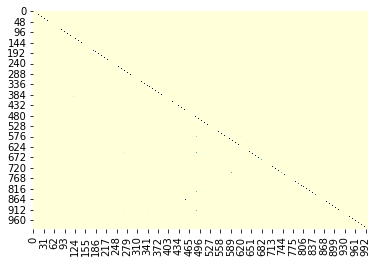

In [15]:
sns.heatmap(preds_text_proba, cmap="YlGnBu", cbar=False)
plt.show()

In [16]:
top_k_accuracy_score(text_labels, preds_text_proba, k=1)

0.909

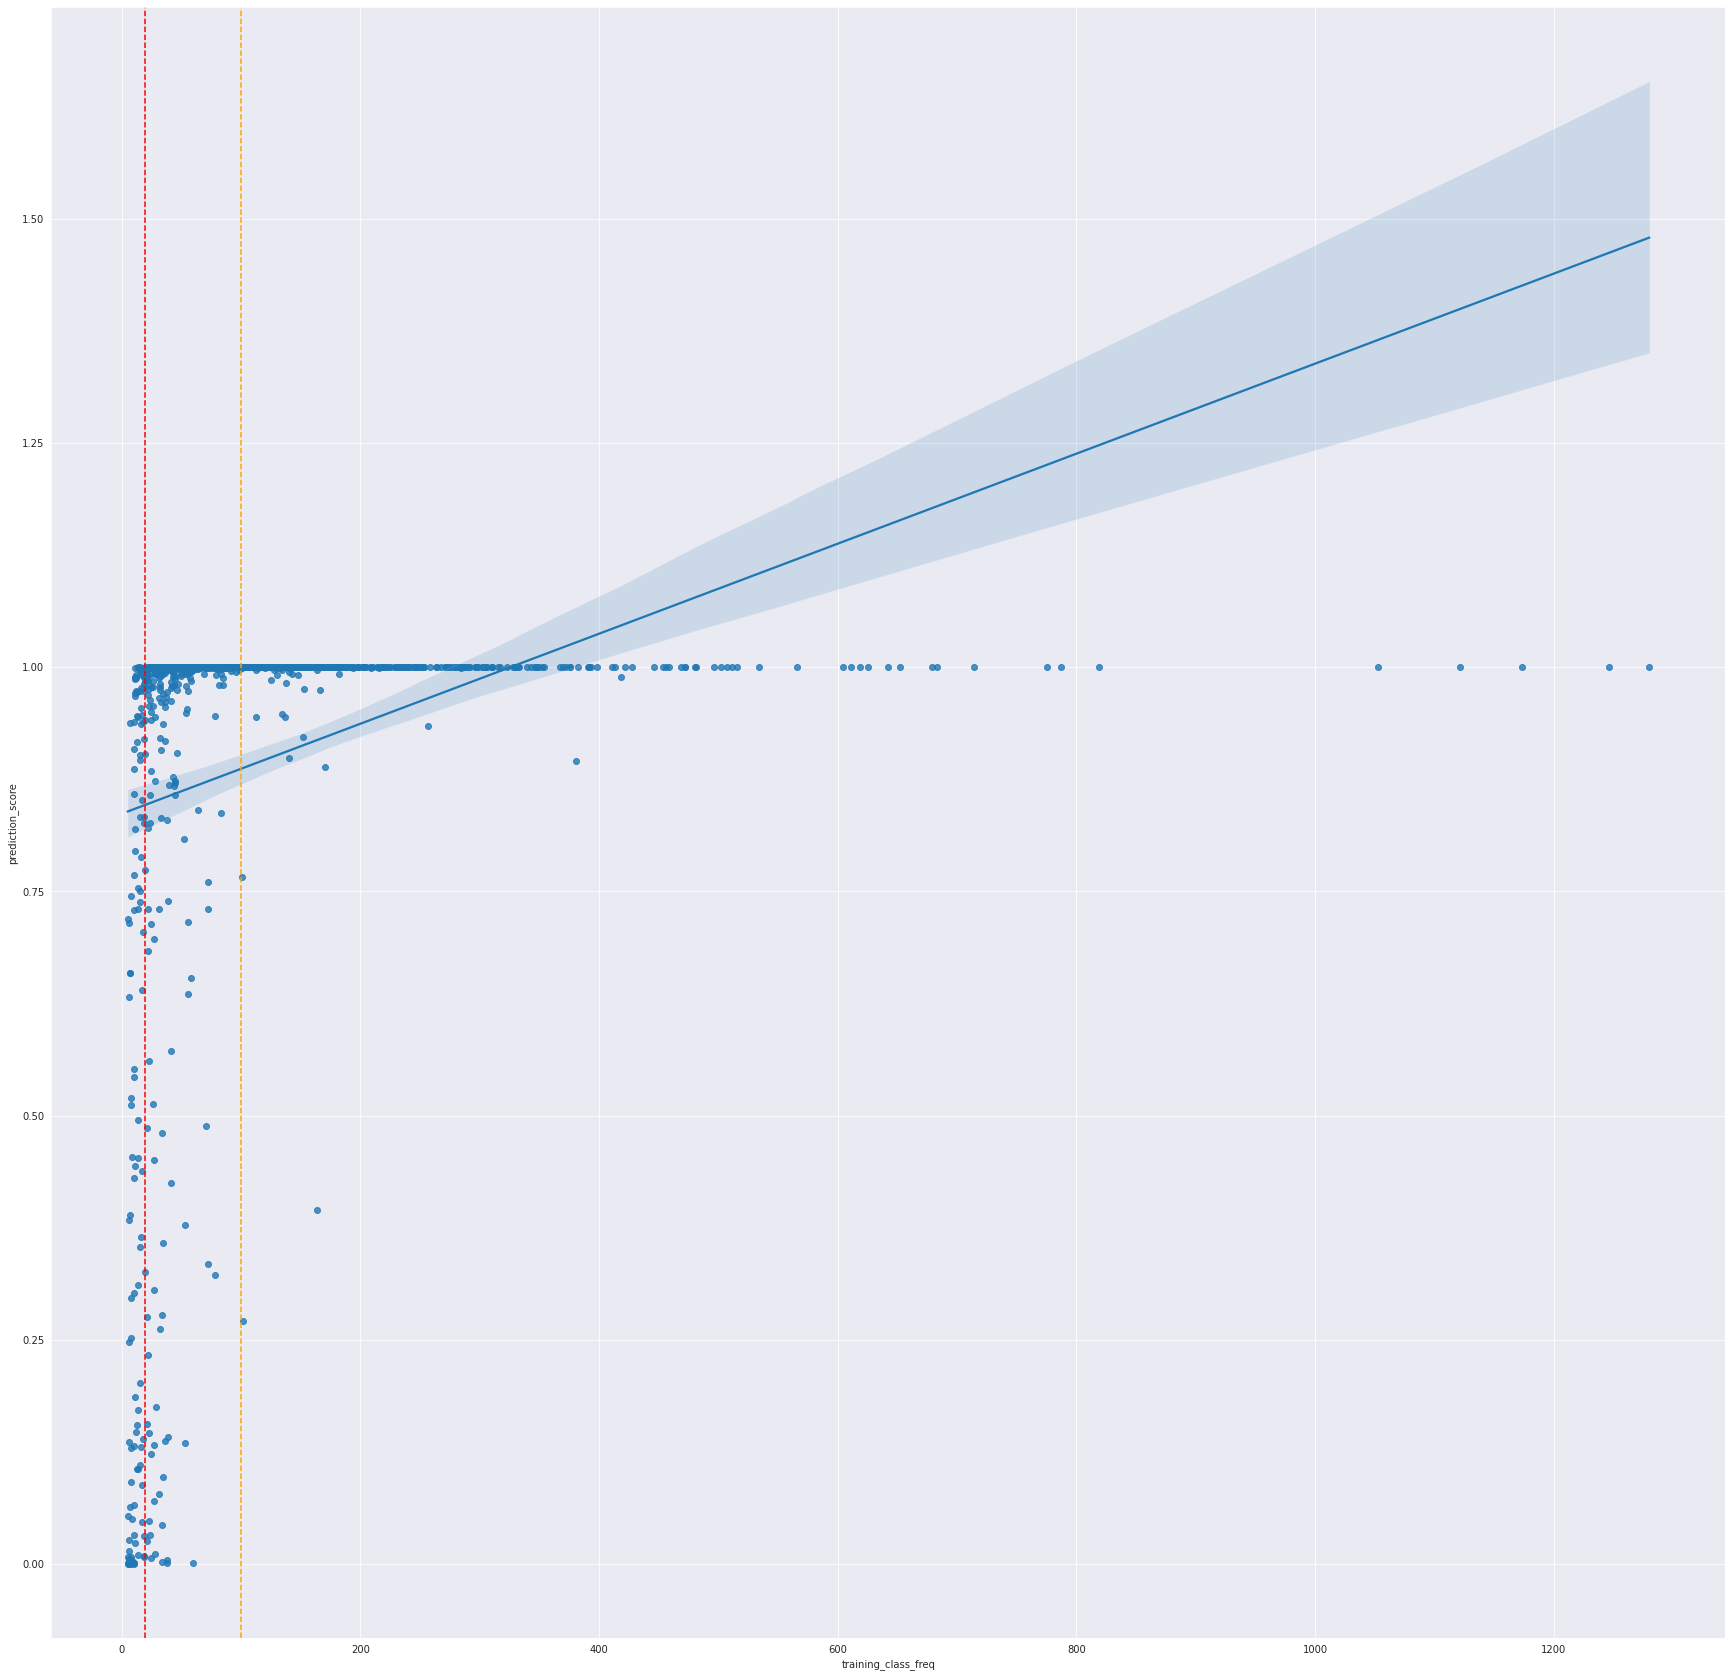

In [143]:
# Correlation between class frequency and text accuracy

import matplotlib.ticker as ticker

sns.set_style("darkgrid")

y = [preds_text_proba[l,l] for l in text_labels]
x = [freqs[l] for l in text_labels]

df = pd.DataFrame()
df["prediction_score"] = y
df["training_class_freq"] = x

graph = sns.regplot(data = df, x = "training_class_freq", y = "prediction_score")
graph.axvline(100, c="orange", linestyle="--")
graph.axvline(20, c="r", linestyle="--")

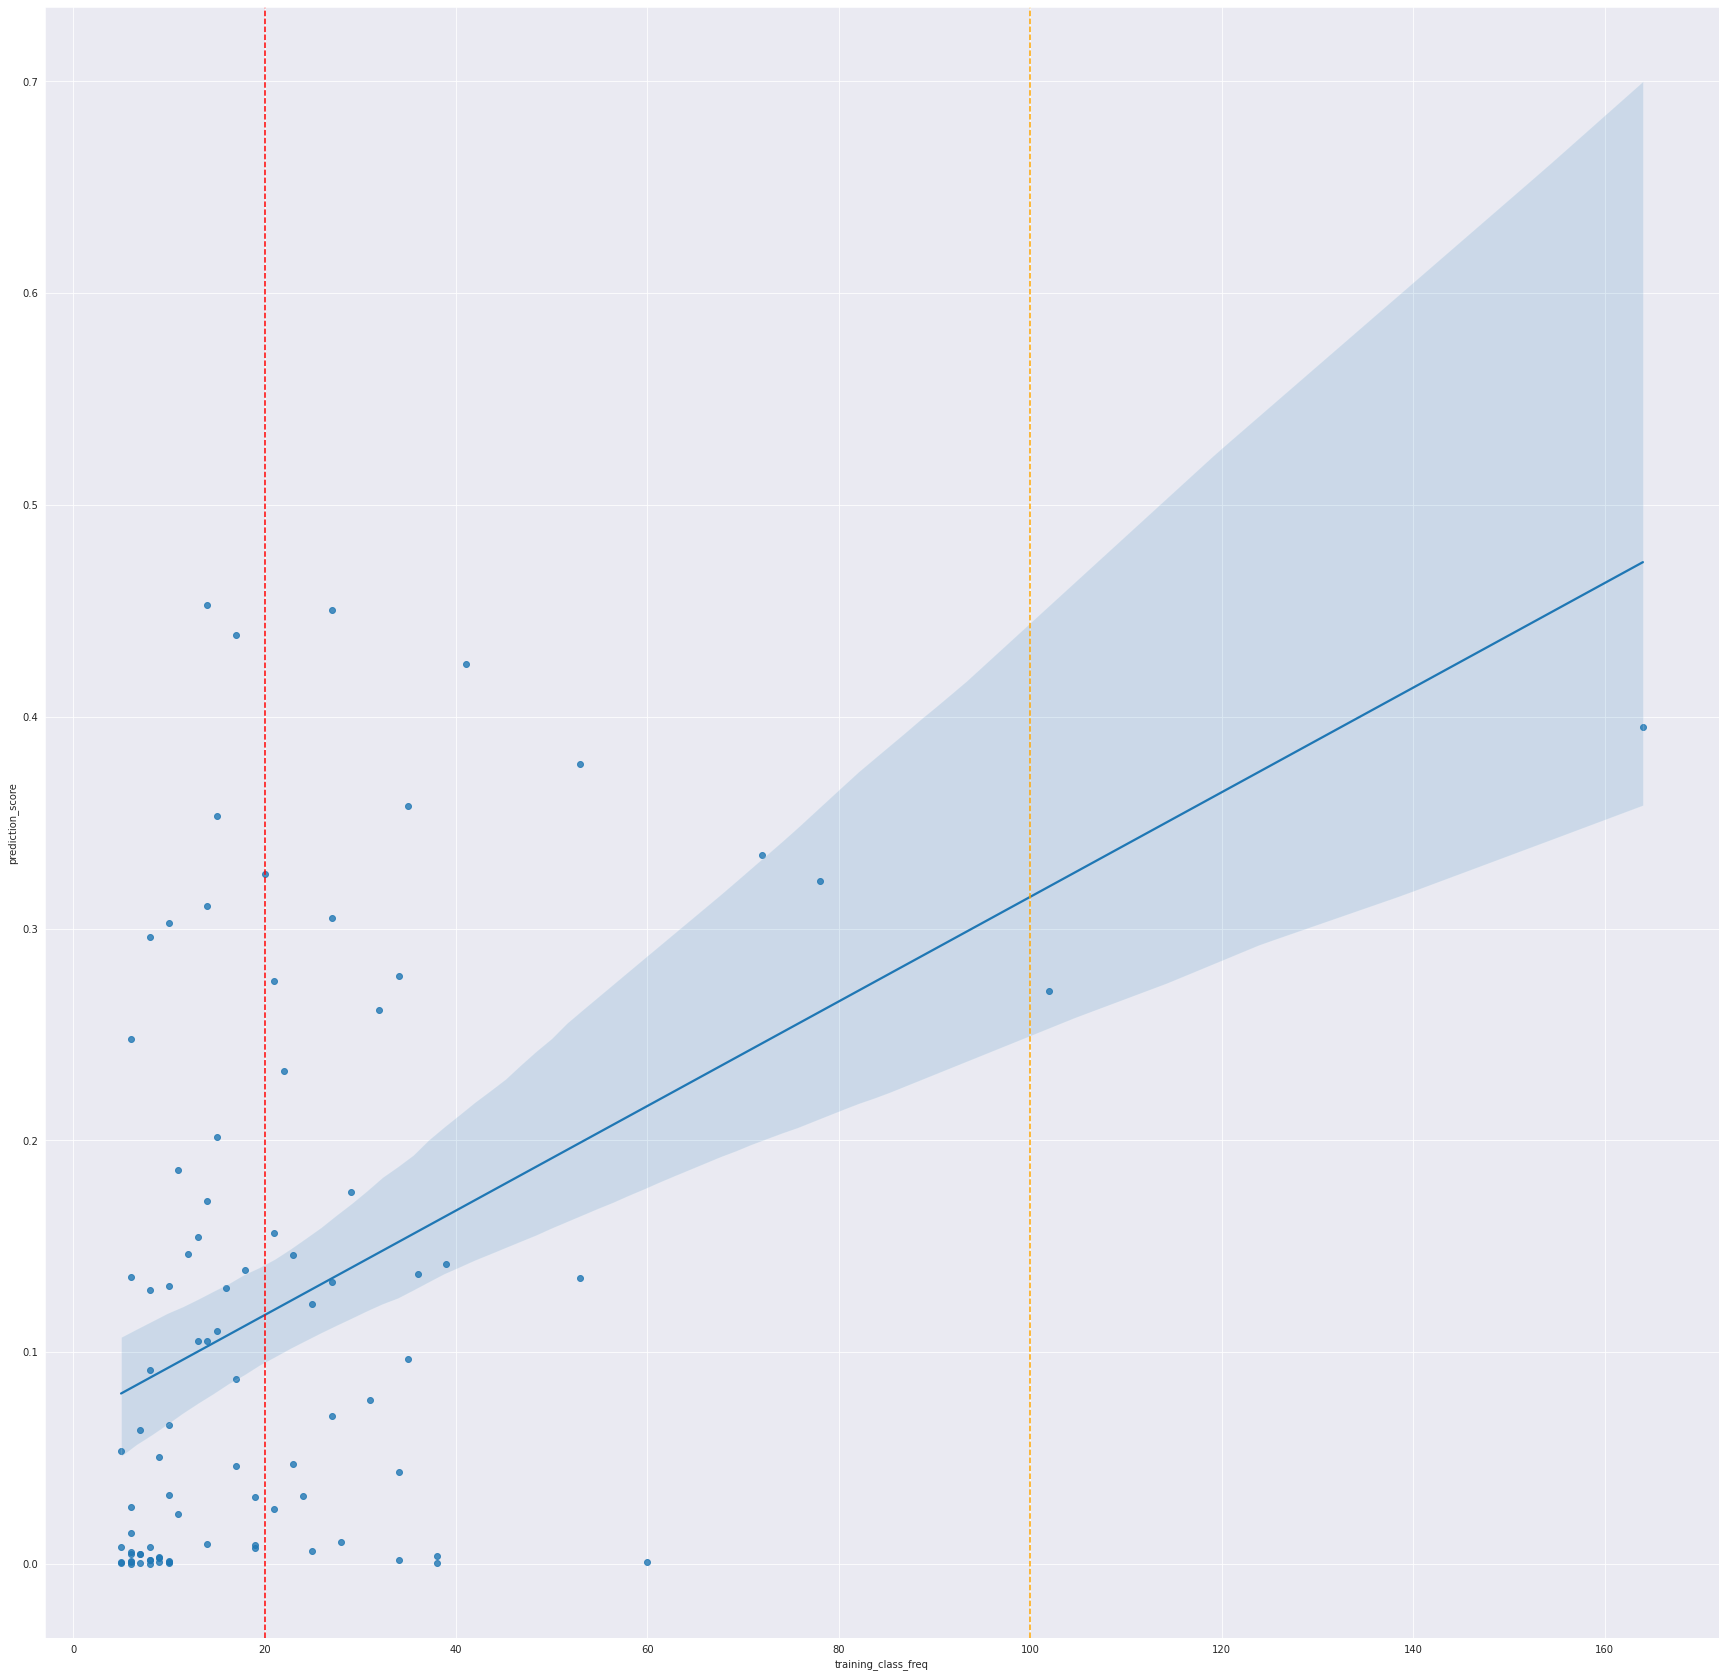

In [142]:
# Correlation between class frequency and text accuracy for incorrect samples

import matplotlib.ticker as ticker

sns.set_style("darkgrid")

y = np.array([preds_text_proba[l,l] for l in text_labels])
x = np.array([freqs[l] for l in text_labels])

inds = np.where(preds_text != text_labels)
y = y[inds]
x = x[inds]

df = pd.DataFrame()
df["prediction_score"] = y
df["training_class_freq"] = x

graph = sns.regplot(data = df, x = "training_class_freq", y = "prediction_score")
graph.axvline(100, c="orange", linestyle="--")
graph.axvline(20, c="r", linestyle="--")

In [144]:
# Understanding outliers

y = np.array([preds_text_proba[l,l] for l in text_labels])
x = np.array([freqs[l] for l in text_labels])
mask = preds_text != text_labels

outliers = []
for i in range(len(x)):
    
    if x[i] > 40:
        if mask[i] == True:
            outliers.append(i)
outliers

[291, 292, 657, 719, 768, 814, 836, 901]

In [145]:
for i in outliers:
    print("Correct:", CLASSES[text_labels[i]])
    print("Training Freq:", x[i])
#     print("Predicted:", CLASSES[preds_text[i]])
    inds = np.array((-preds_text_proba[i]).argsort()[:3])
    print("Predicted top 3:",np.array(CLASSES)[inds])
    print("Predicted top 3 prob:",preds_text_proba[i][inds])
    print("-------------")

Correct: lion
Training Freq: 53
Predicted top 3: ['grey wolf' 'lion' 'mushroom']
Predicted top 3 prob: [0.44594173 0.37760857 0.09185849]
-------------
Correct: tiger
Training Freq: 53
Predicted top 3: ['tiger shark' 'tiger' 'grey wolf']
Predicted top 3 prob: [0.7577292  0.13521528 0.02855057]
-------------
Correct: missile
Training Freq: 72
Predicted top 3: ['missile' 'missile' 'mobile phone']
Predicted top 3 prob: [0.63602124 0.3348065  0.01187539]
-------------
Correct: piggy bank
Training Freq: 78
Predicted top 3: ['pig' 'piggy bank' 'water jug']
Predicted top 3 prob: [6.76708409e-01 3.22596415e-01 2.00536083e-04]
-------------
Correct: rugby ball
Training Freq: 164
Predicted top 3: ['soccer ball' 'rugby ball' 'balloon']
Predicted top 3 prob: [0.53718628 0.39523327 0.06663741]
-------------
Correct: motorboat
Training Freq: 41
Predicted top 3: ['mobile phone' 'motorboat' 'amphibious vehicle']
Predicted top 3 prob: [0.54923541 0.42486627 0.00281839]
-------------
Correct: sunglasses

### Image Bias?

In [21]:
preds_im_proba = clf.predict_proba(image_embeddings.cpu())
preds_im = clf.predict(image_embeddings.cpu())

In [146]:
preds_im_proba_avg = np.zeros((1000,1000))
for i in range(50000):
    indx = labels[i]
    vals = preds_im_proba[i]
    preds_im_proba_avg[indx] += vals
    
preds_im_proba_avg /=50

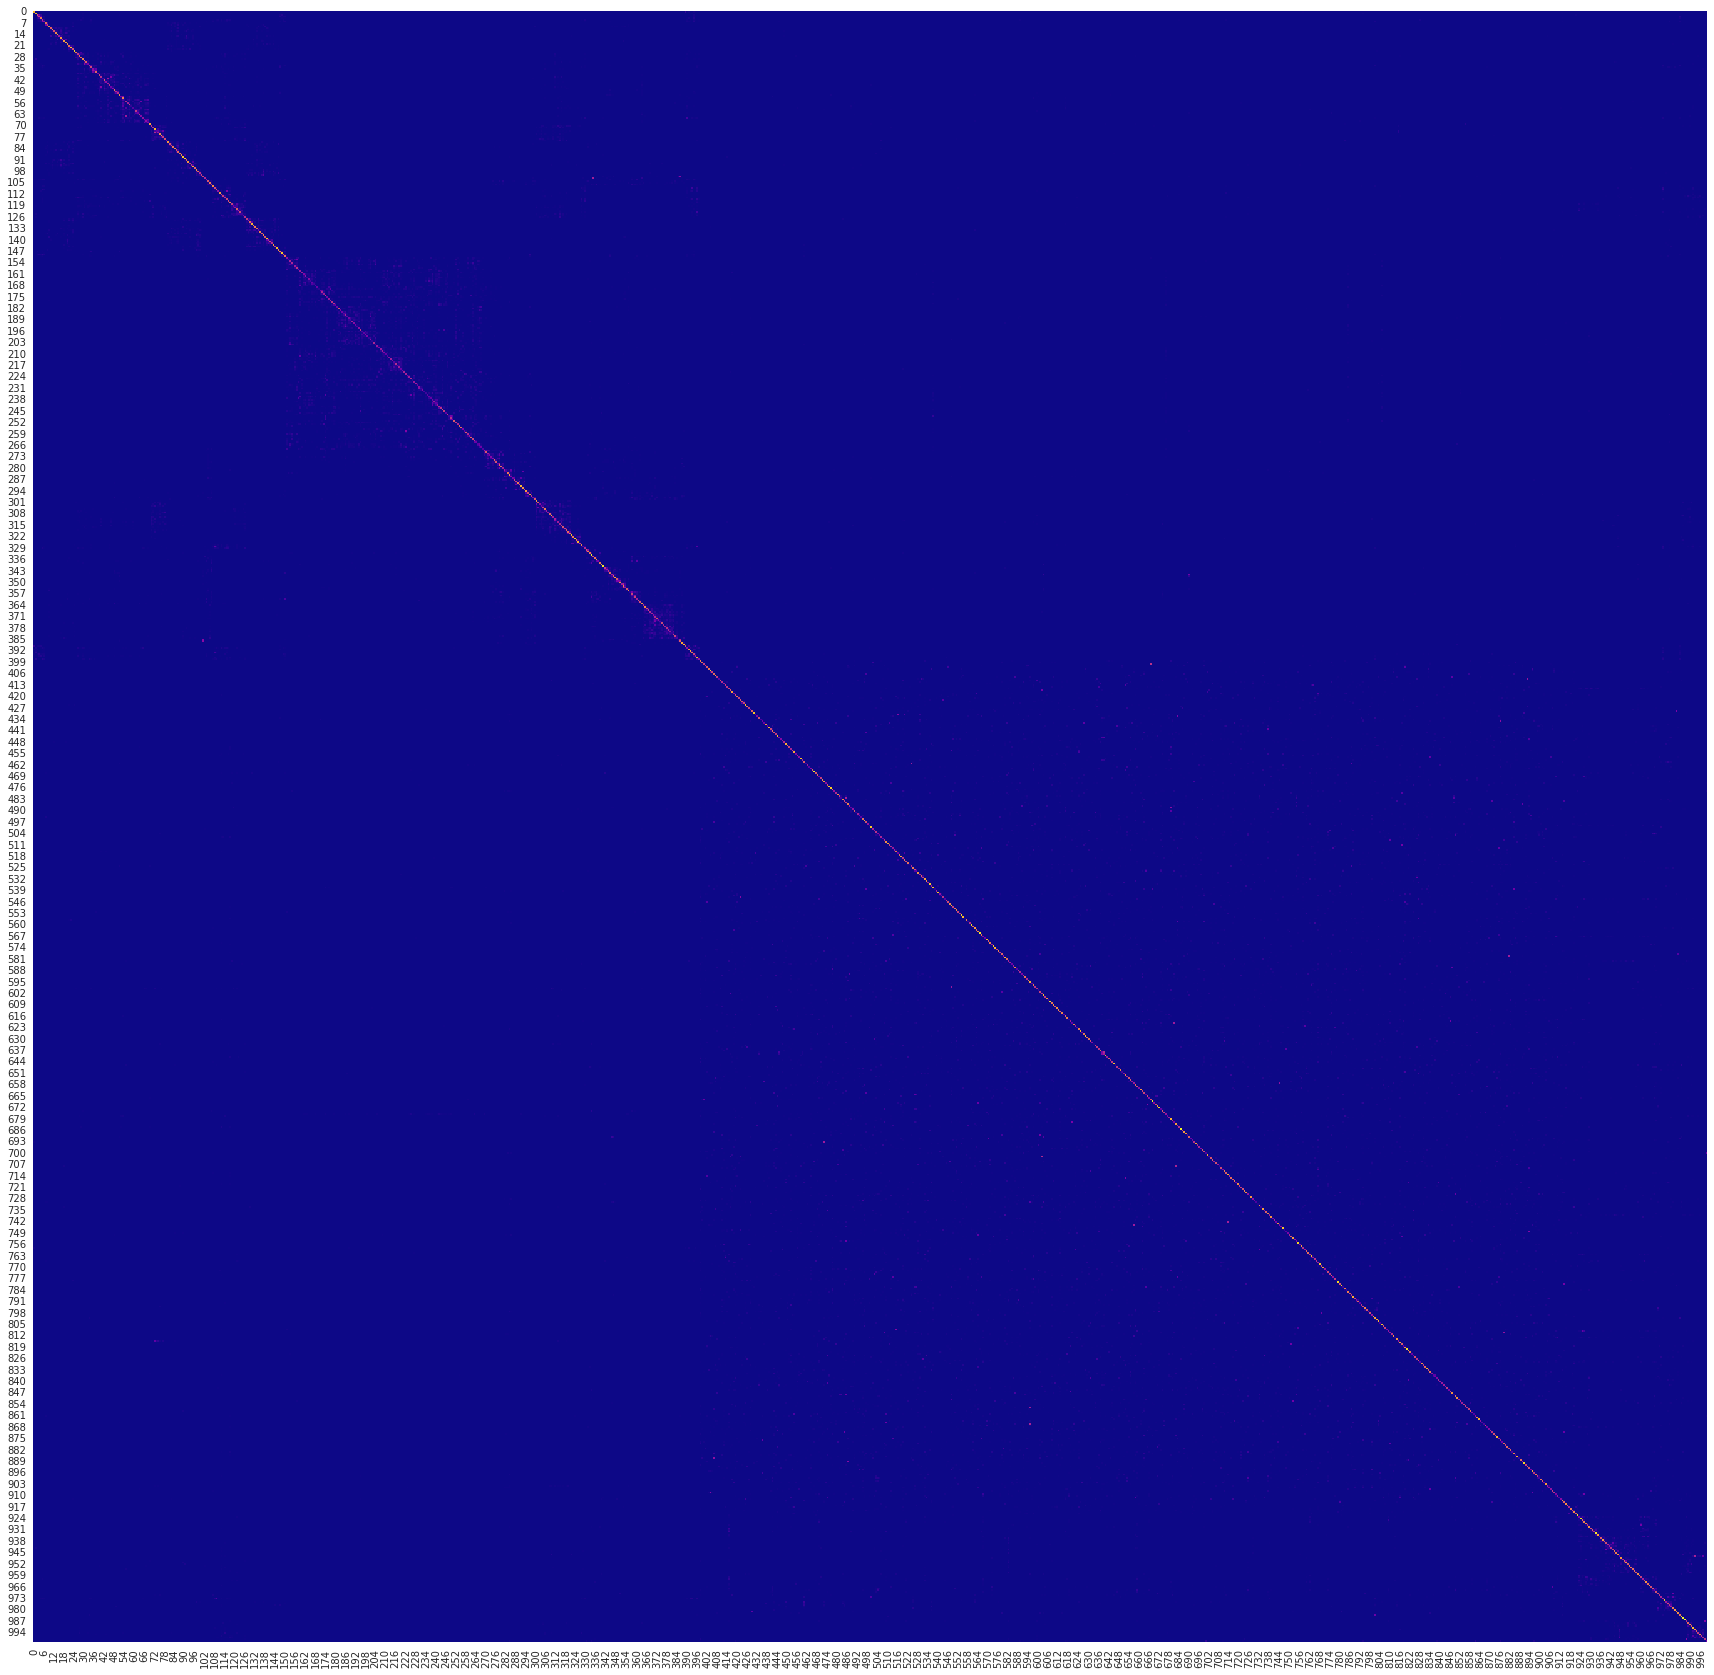

In [147]:
sns.heatmap(preds_im_proba_avg, cmap="plasma", cbar=False)
plt.show()

In [24]:
top_k_accuracy_score(labels, preds_im_proba, k=1)

0.62202

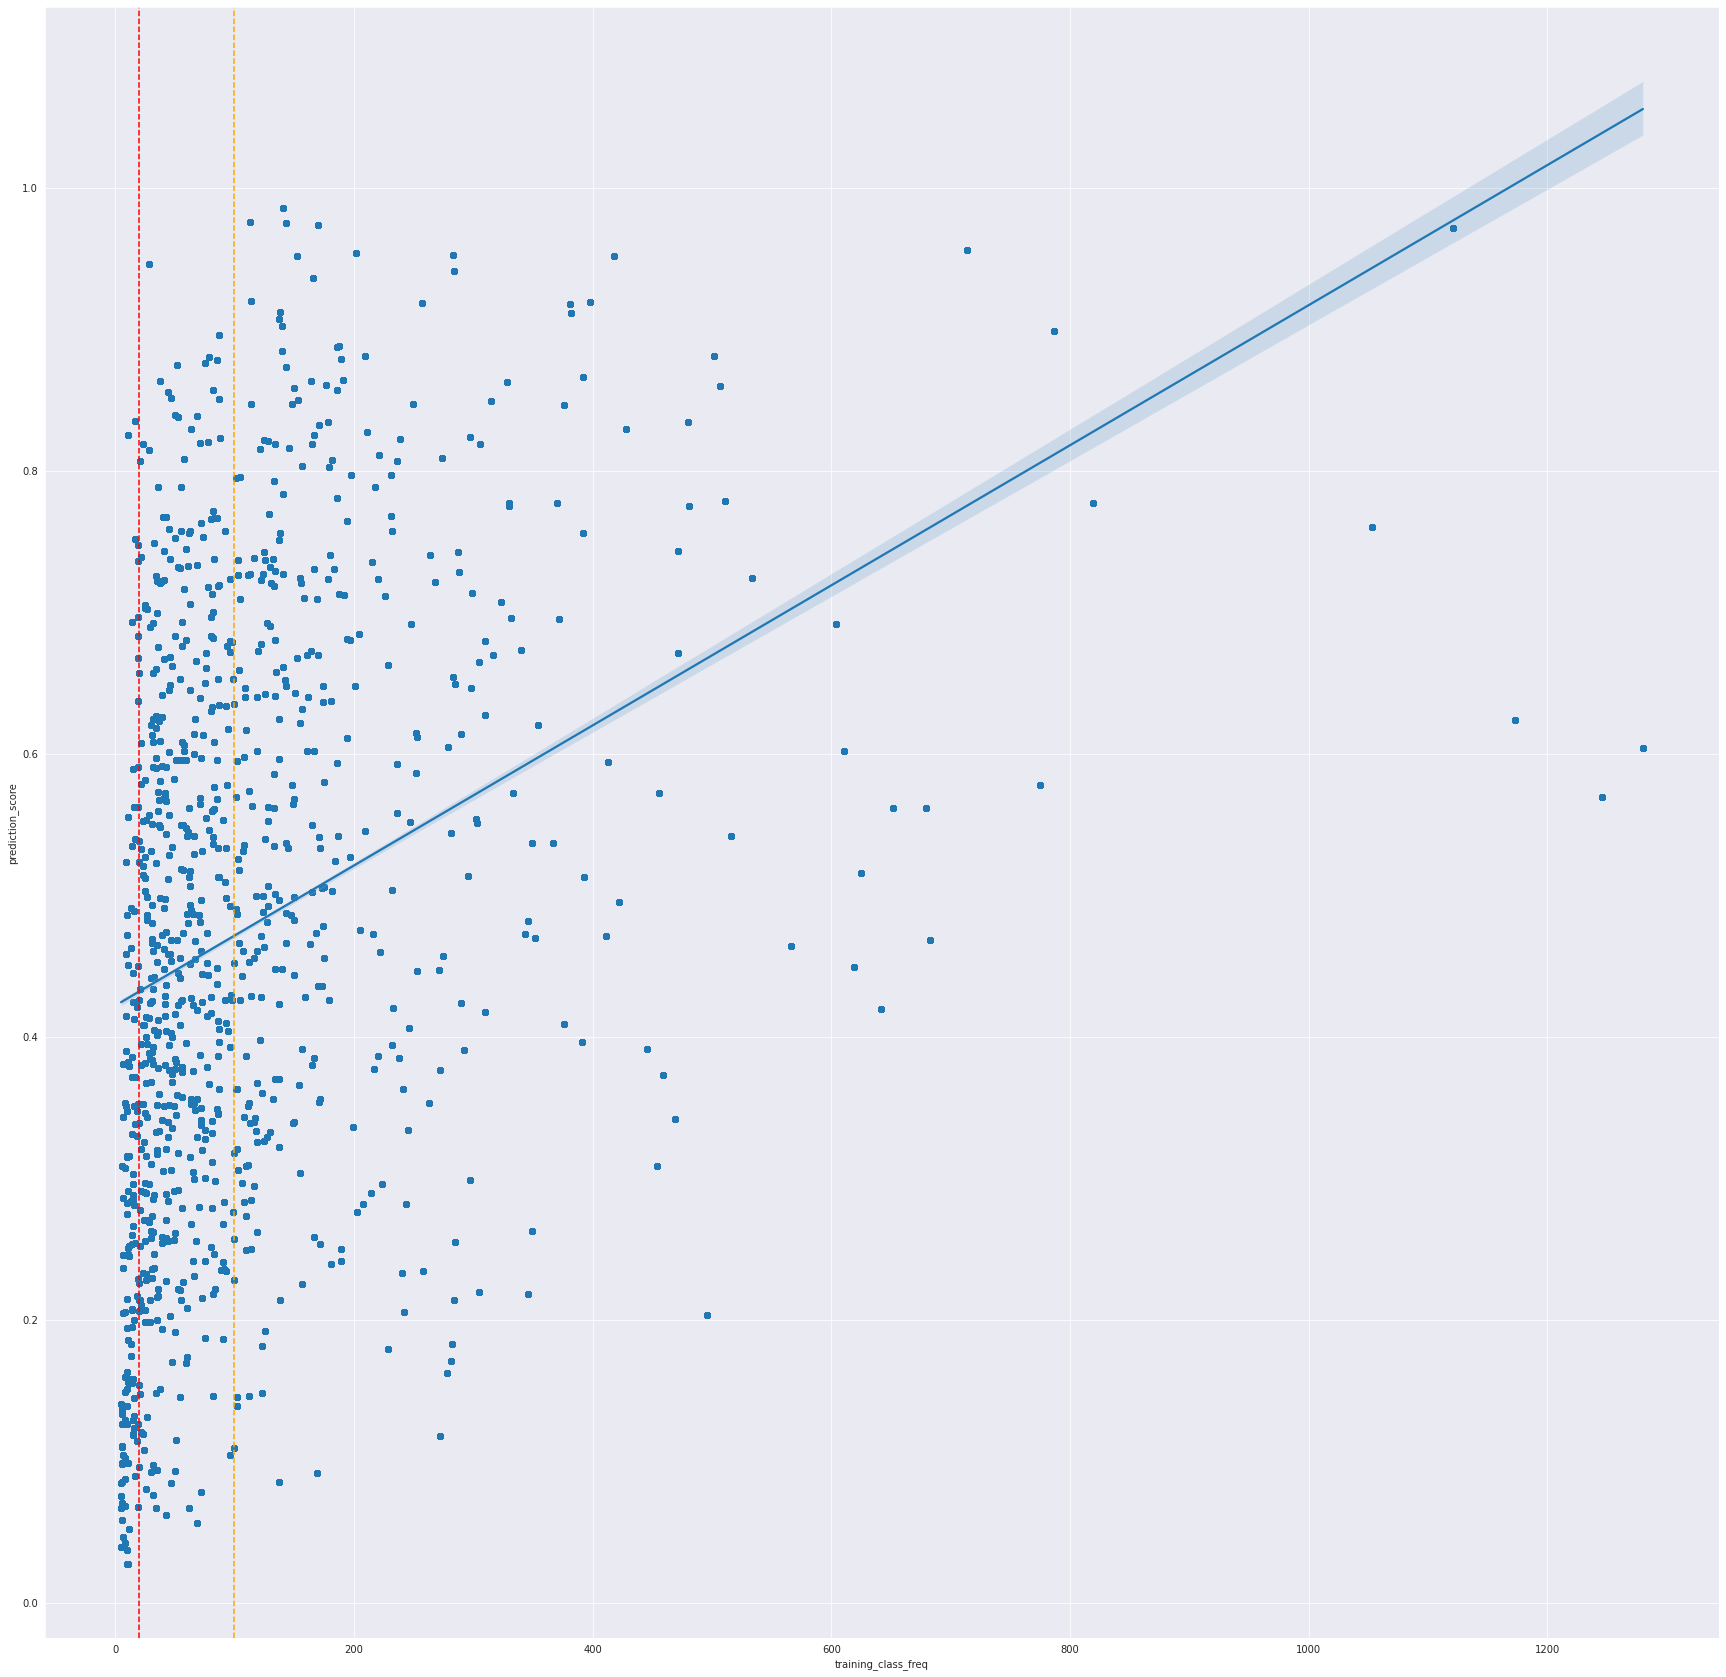

In [148]:
# Correlation between class frequency and image accuracy

import matplotlib.ticker as ticker

sns.set_style("darkgrid")

y = [preds_im_proba_avg[l,l] for l in labels]
x = [freqs[l.item()] for l in labels]

df = pd.DataFrame()
df["prediction_score"] = y
df["training_class_freq"] = x

graph = sns.regplot(data = df, x = "training_class_freq", y = "prediction_score")
graph.axvline(100, c="orange", linestyle="--")
graph.axvline(20, c="r", linestyle="--")

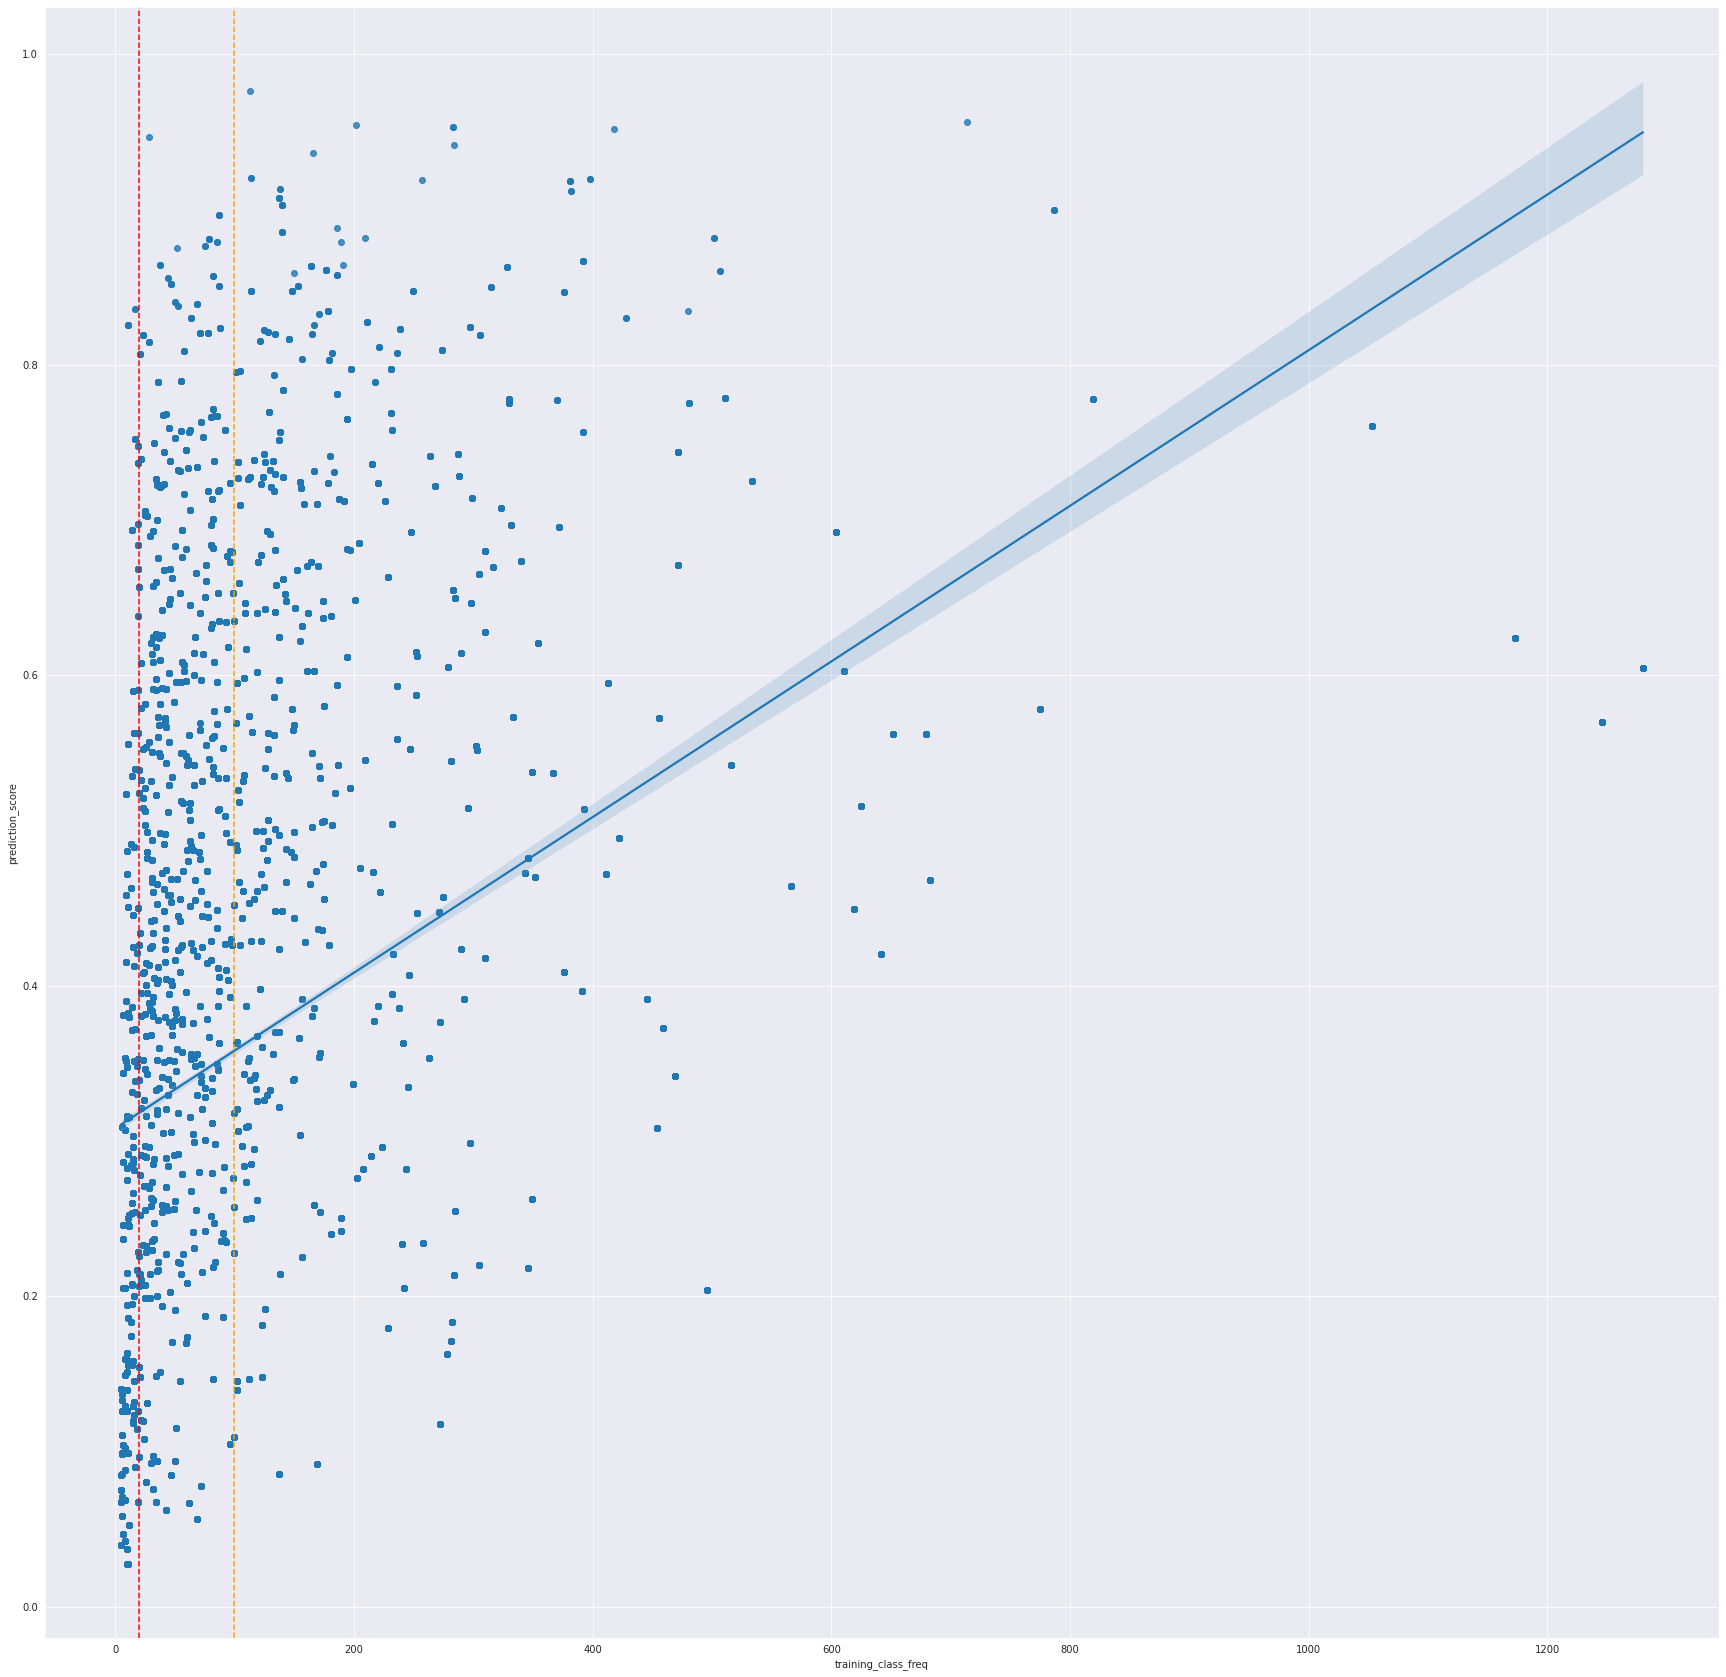

In [149]:
# Correlation between class frequency and text accuracy for incorrect samples

import matplotlib.ticker as ticker

sns.set_style("darkgrid")

y = np.array([preds_im_proba_avg[l,l] for l in labels])
x = np.array([freqs[l.item()] for l in labels])

inds = np.where(np.not_equal(preds_im,labels))
y = y[inds]
x = x[inds]

df = pd.DataFrame()
df["prediction_score"] = y
df["training_class_freq"] = x

graph = sns.regplot(data = df, x = "training_class_freq", y = "prediction_score")
graph.axvline(100, c="orange", linestyle="--")
graph.axvline(20, c="r", linestyle="--")

### Best we can do at Eval Time

In [27]:
true_text_prompts = text_embs[labels]
true_text_prompts.shape

torch.Size([50000, 1024])

In [177]:
conv_comb_test = 0.8*(many_embs.cpu()) + 0.2*(text_embs[many_labels].cpu())
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, many_labels)
print("Many", avg_acc)
conv_comb_test = 0.8*(med_embs.cpu()) + 0.2*(text_embs[med_labels].cpu())
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, med_labels)
print("Med", avg_acc)
conv_comb_test = 0.8*(few_embs.cpu()) + 0.2*(text_embs[few_labels].cpu())
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, few_labels)
print("Few", avg_acc)
conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(true_text_prompts.cpu())
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
print("All", avg_acc)

Many 0.9875703324808184
Med 0.9234672304439746
Few 0.6354411764705883
All 0.90936


  0%|          | 0/1000 [00:00<?, ?it/s]

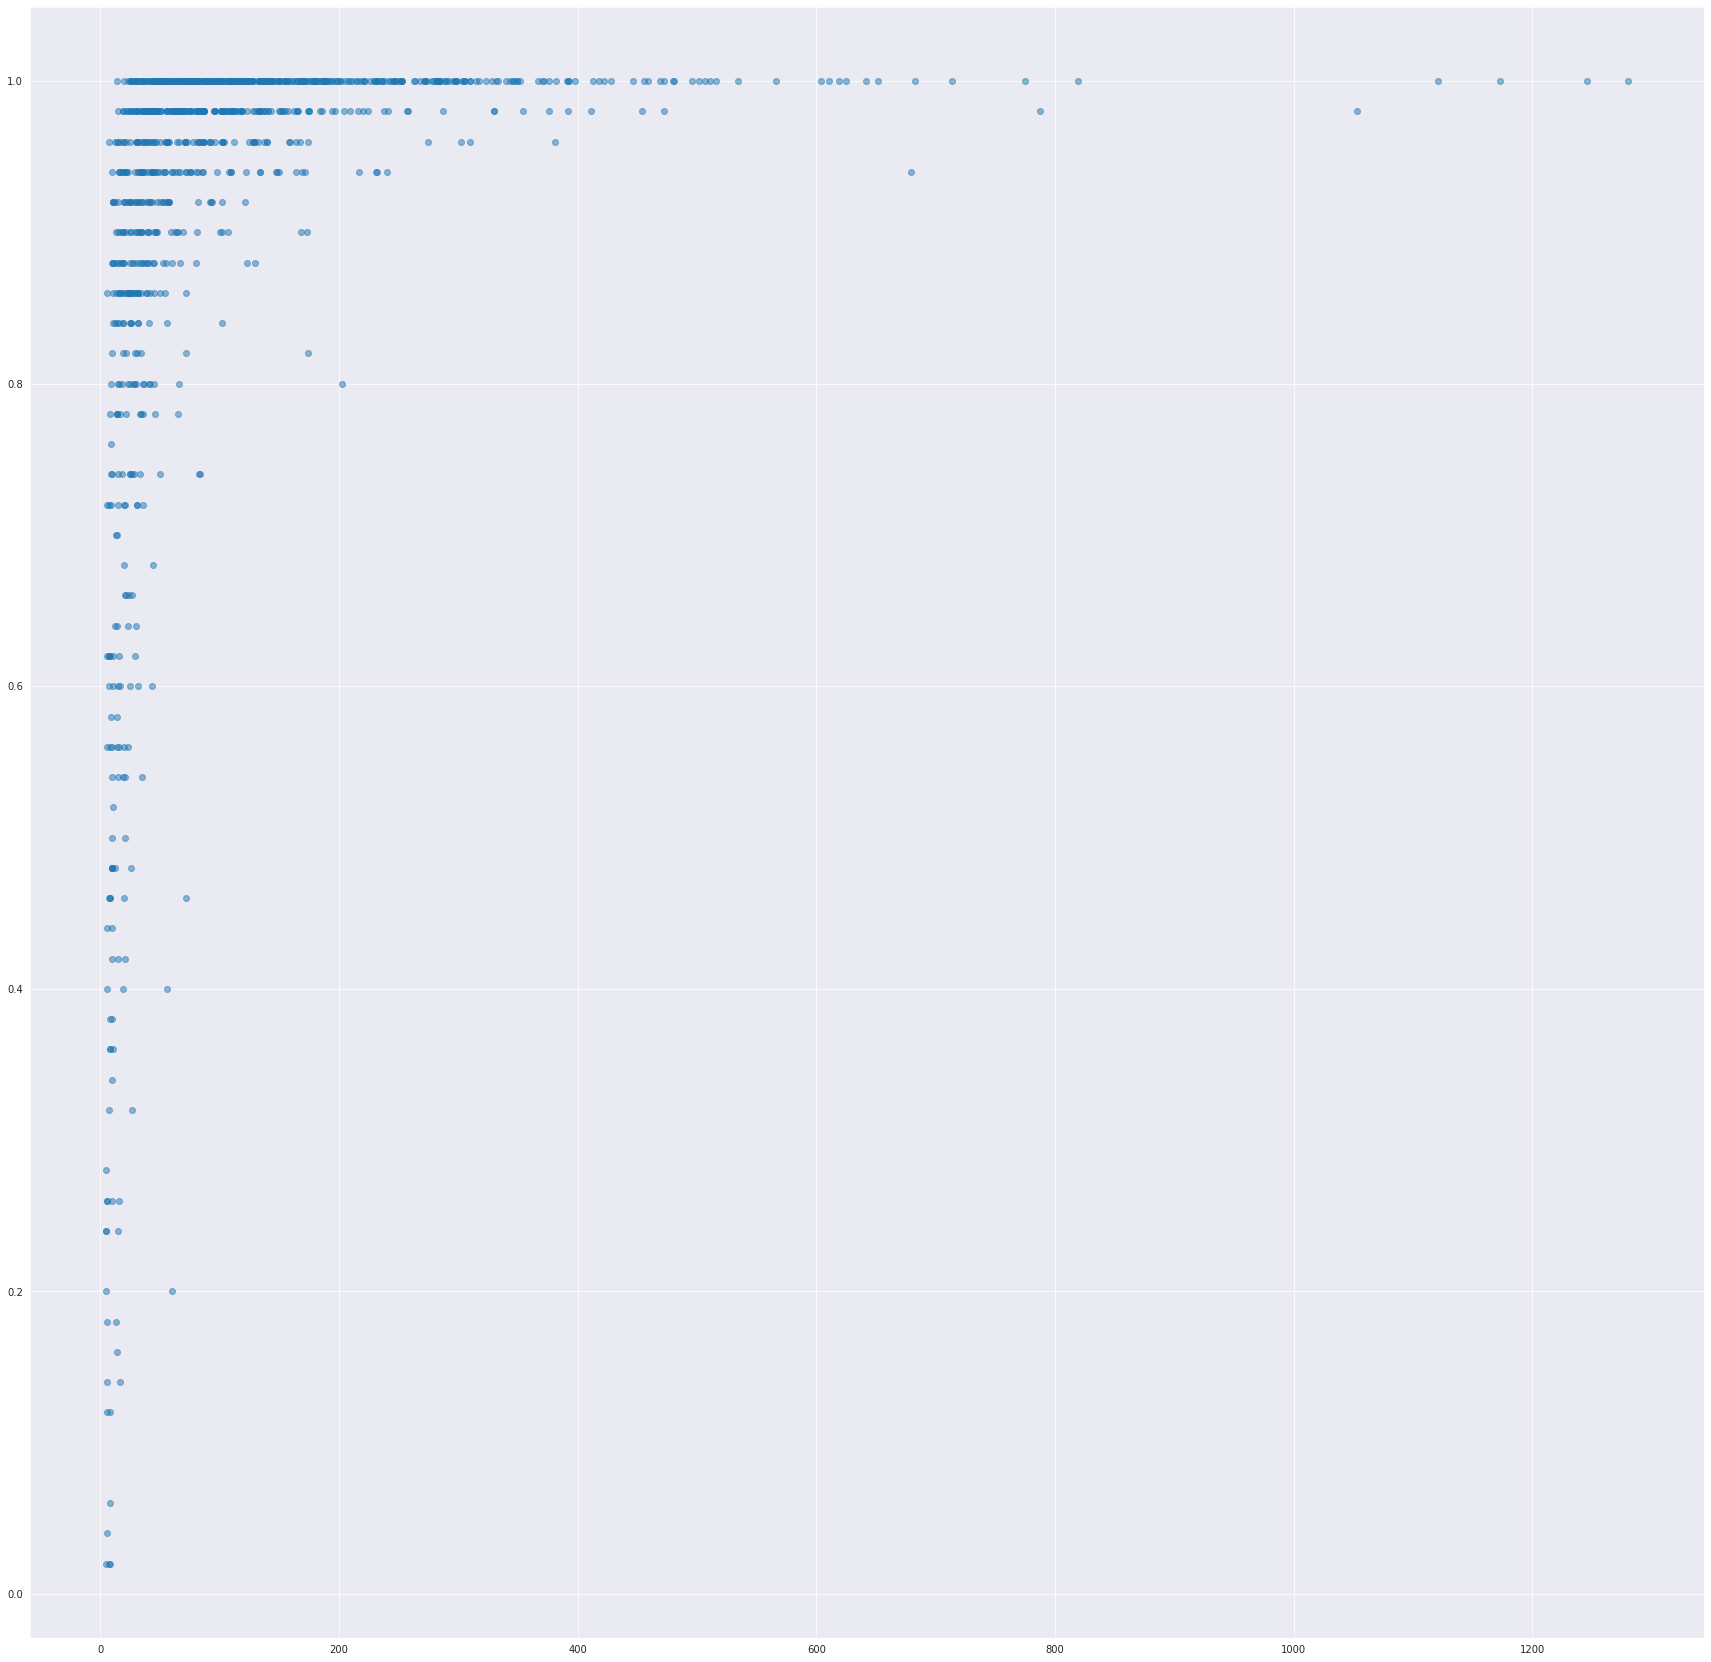

In [159]:
accs = []
cls_freqs = []
for cls in tqdm(range(1000)):
    m = labels == cls
    indices = m.nonzero()
    acc = mic_acc_cal(predictions_conv_comb_test[indices], labels[indices].numpy())
    accs.append(acc)
    cls_freqs.append(freqs[int(cls)])
    
sns.set_style("darkgrid")
plt.scatter(cls_freqs, accs, alpha=0.5)

In [160]:
conv_comb_test = true_text_prompts.cpu()
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
print(avg_acc)

0.909


  0%|          | 0/1000 [00:00<?, ?it/s]

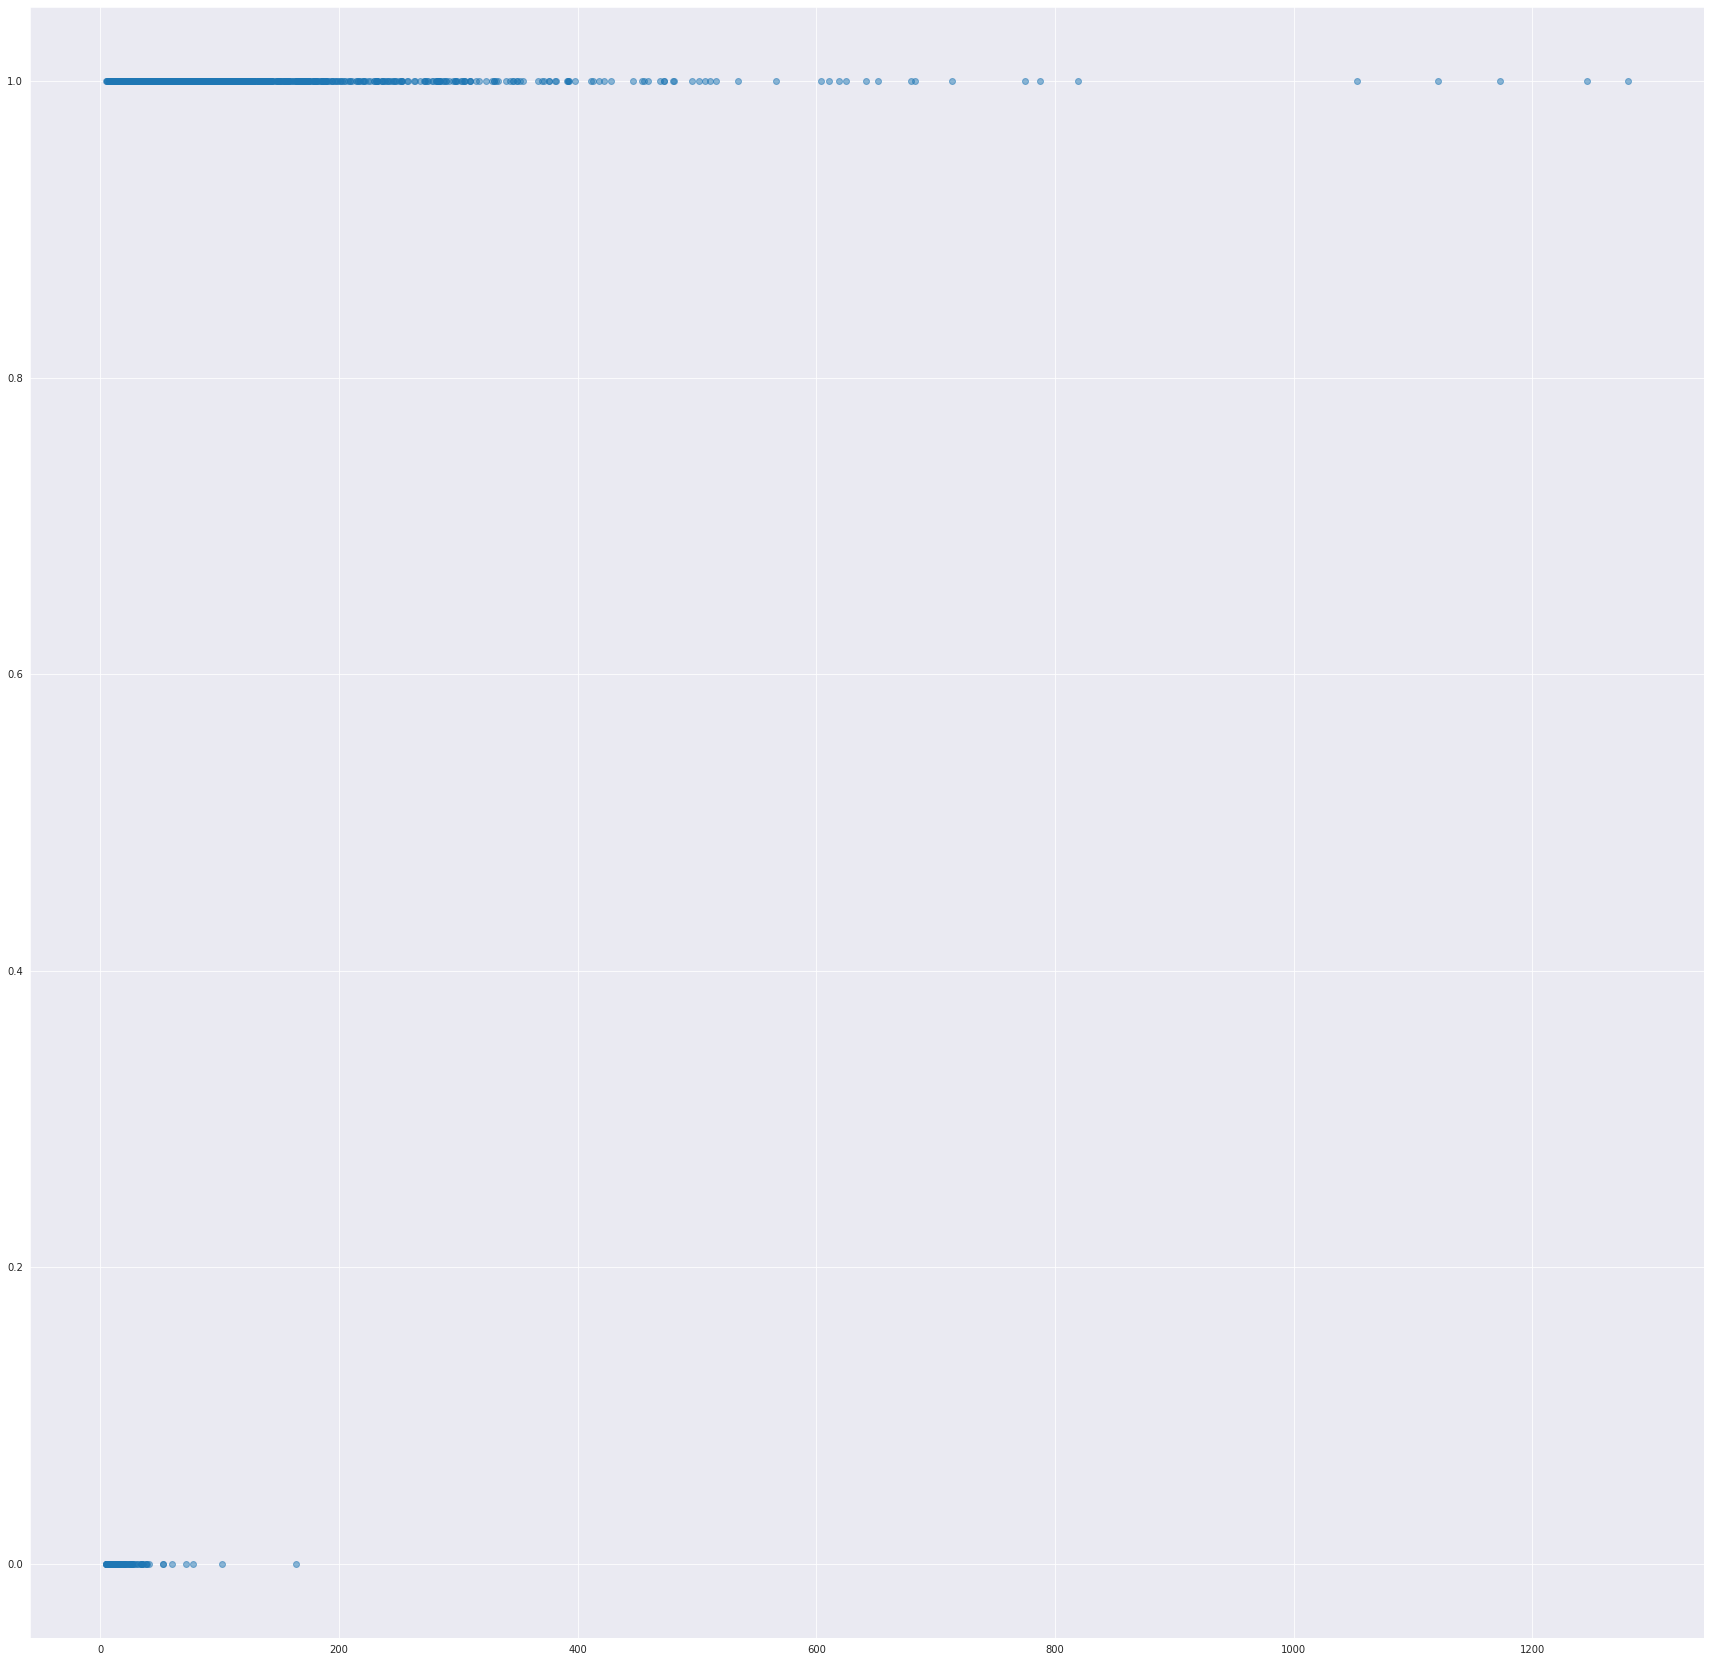

In [153]:
accs_text_only = []
cls_freqs_text_only = []
for cls in tqdm(labels.unique()):
    m = labels == cls
    indices = m.nonzero()
    acc = mic_acc_cal(predictions_conv_comb_test[indices], labels[indices].numpy())
    accs_text_only.append(acc)
    cls_freqs_text_only.append(freqs[int(cls)])
    
sns.set_style("darkgrid")
plt.scatter(cls_freqs_text_only, accs_text_only, alpha=0.5)

/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:>

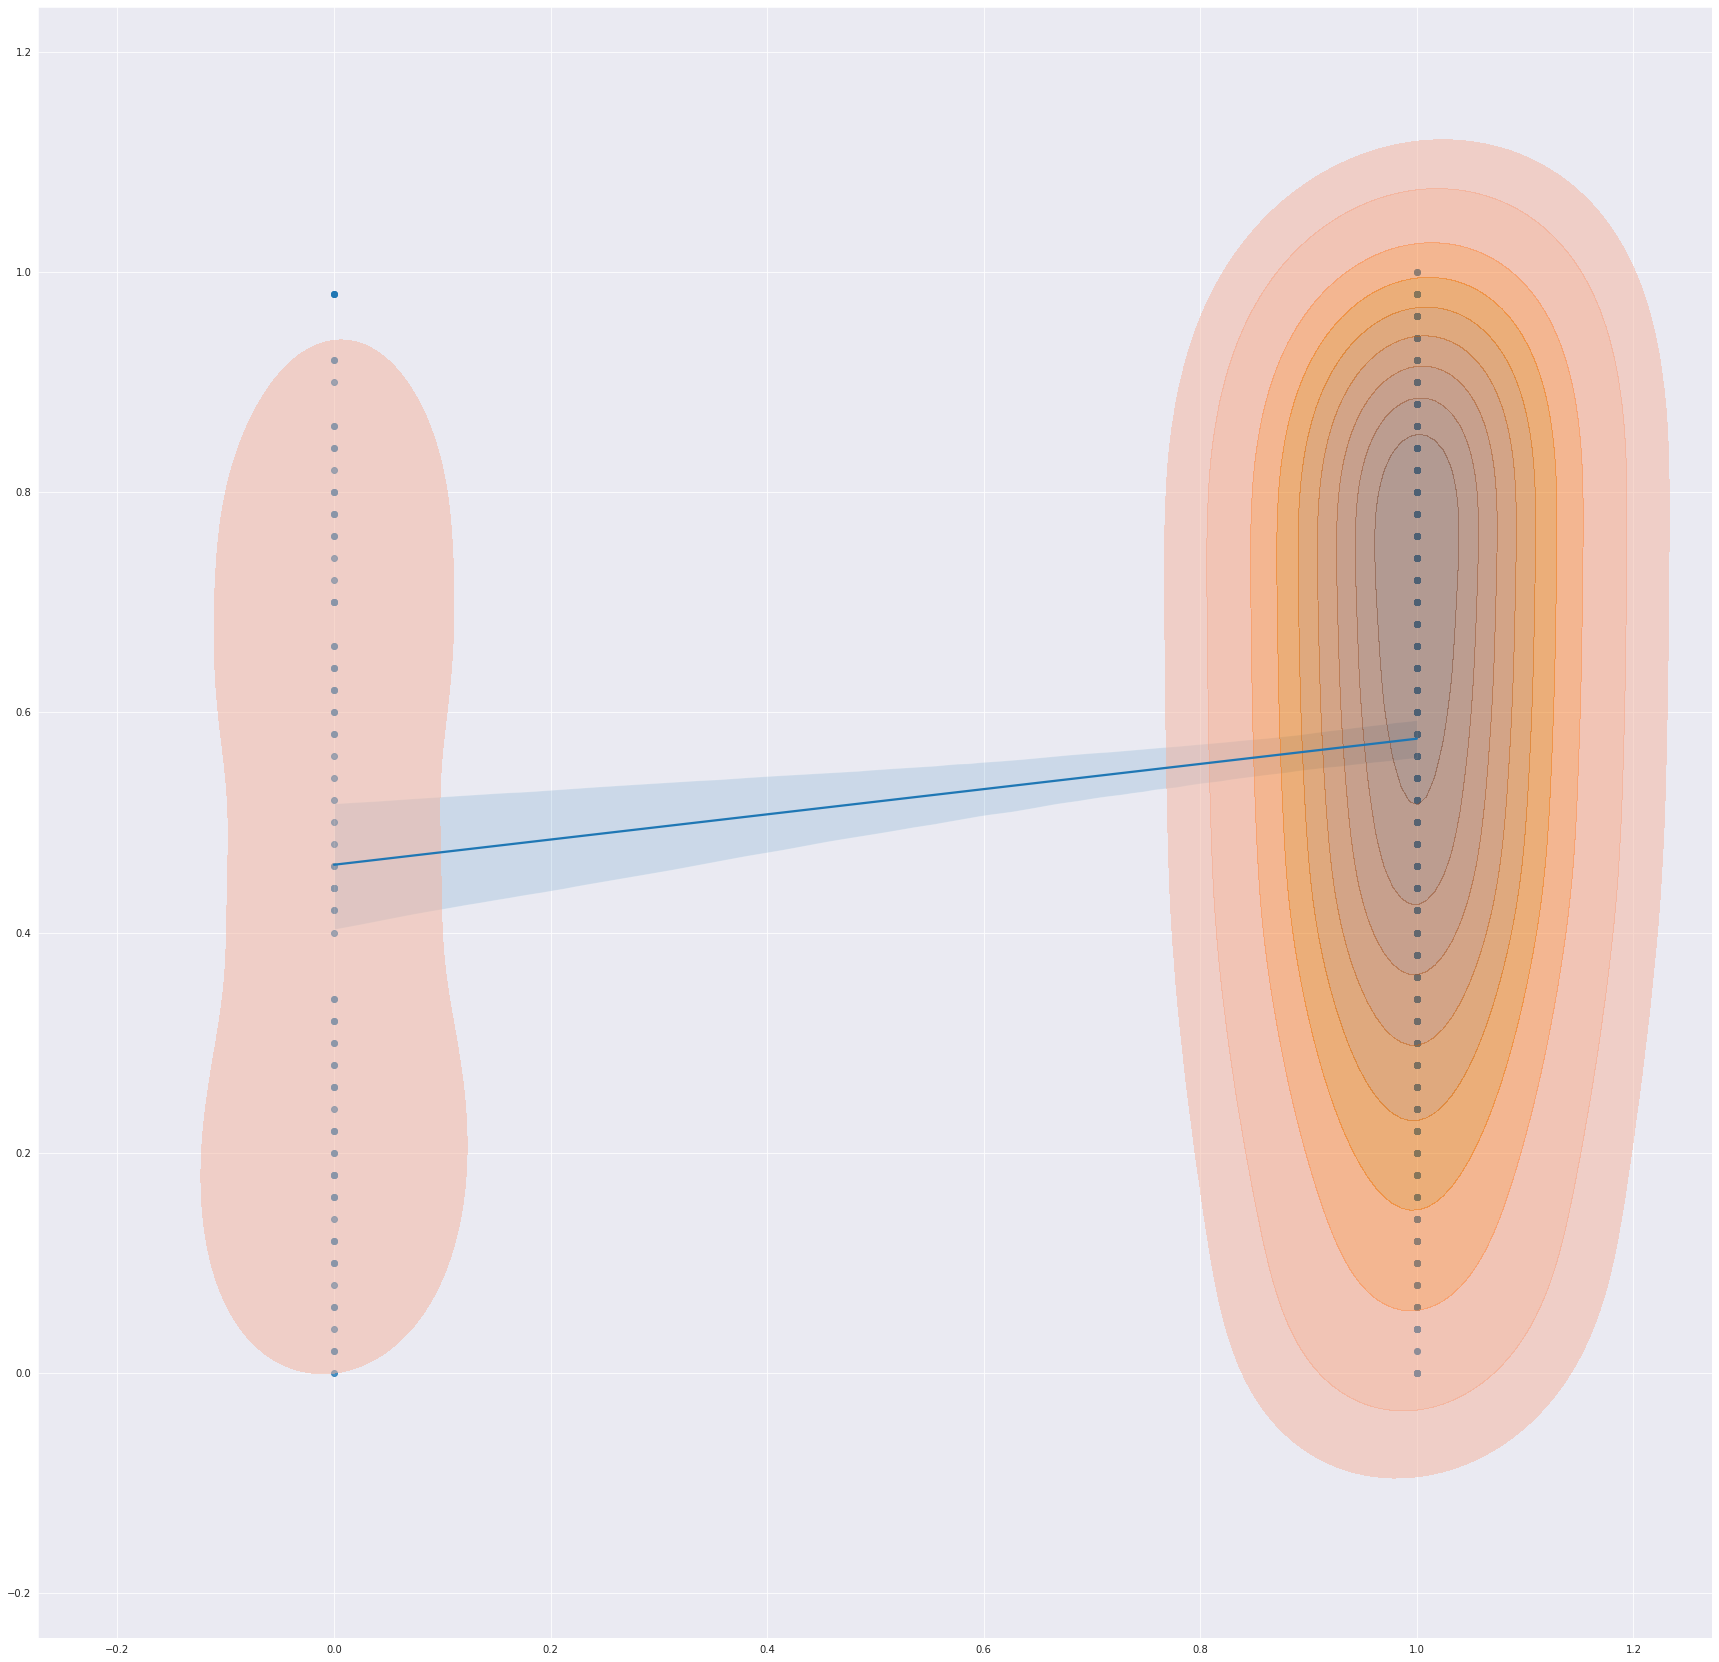

In [154]:
sns.regplot(accs_text_only, accs)
sns.kdeplot(accs_text_only, accs,fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)

### Add closest text at eval time

In [33]:
# Pairwise cosine similarity between image and text 
import sklearn 
pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), text_embs.cpu())
pairwise_cs.shape

(50000, 1000)

In [182]:
# add to the most similar text

indices = np.argmax(pairwise_cs, axis=-1)
most_similar_text = np.take_along_axis(text_embs.cpu(), indices[:,None], axis=0)
print(most_similar_text.shape)

# conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_text)
# predictions_conv_comb_test = clf.predict(conv_comb_test)
# avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
# print(avg_acc)

torch.Size([50000, 1024])


In [183]:
conv_comb_test = 0.8*(many_embs.cpu()) + 0.2*(most_similar_text[many_labels])
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, many_labels)
print("Many", avg_acc)
conv_comb_test = 0.8*(med_embs.cpu()) + 0.2*(most_similar_text[med_labels])
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, med_labels)
print("Med", avg_acc)
conv_comb_test = 0.8*(few_embs.cpu()) + 0.2*(most_similar_text[few_labels])
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, few_labels)
print("Few", avg_acc)
conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_text)
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
print("All", avg_acc)

Many 0.6765217391304348
Med 0.5395348837209303
Few 0.35441176470588237
All 0.59572


  0%|          | 0/1000 [00:00<?, ?it/s]

/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

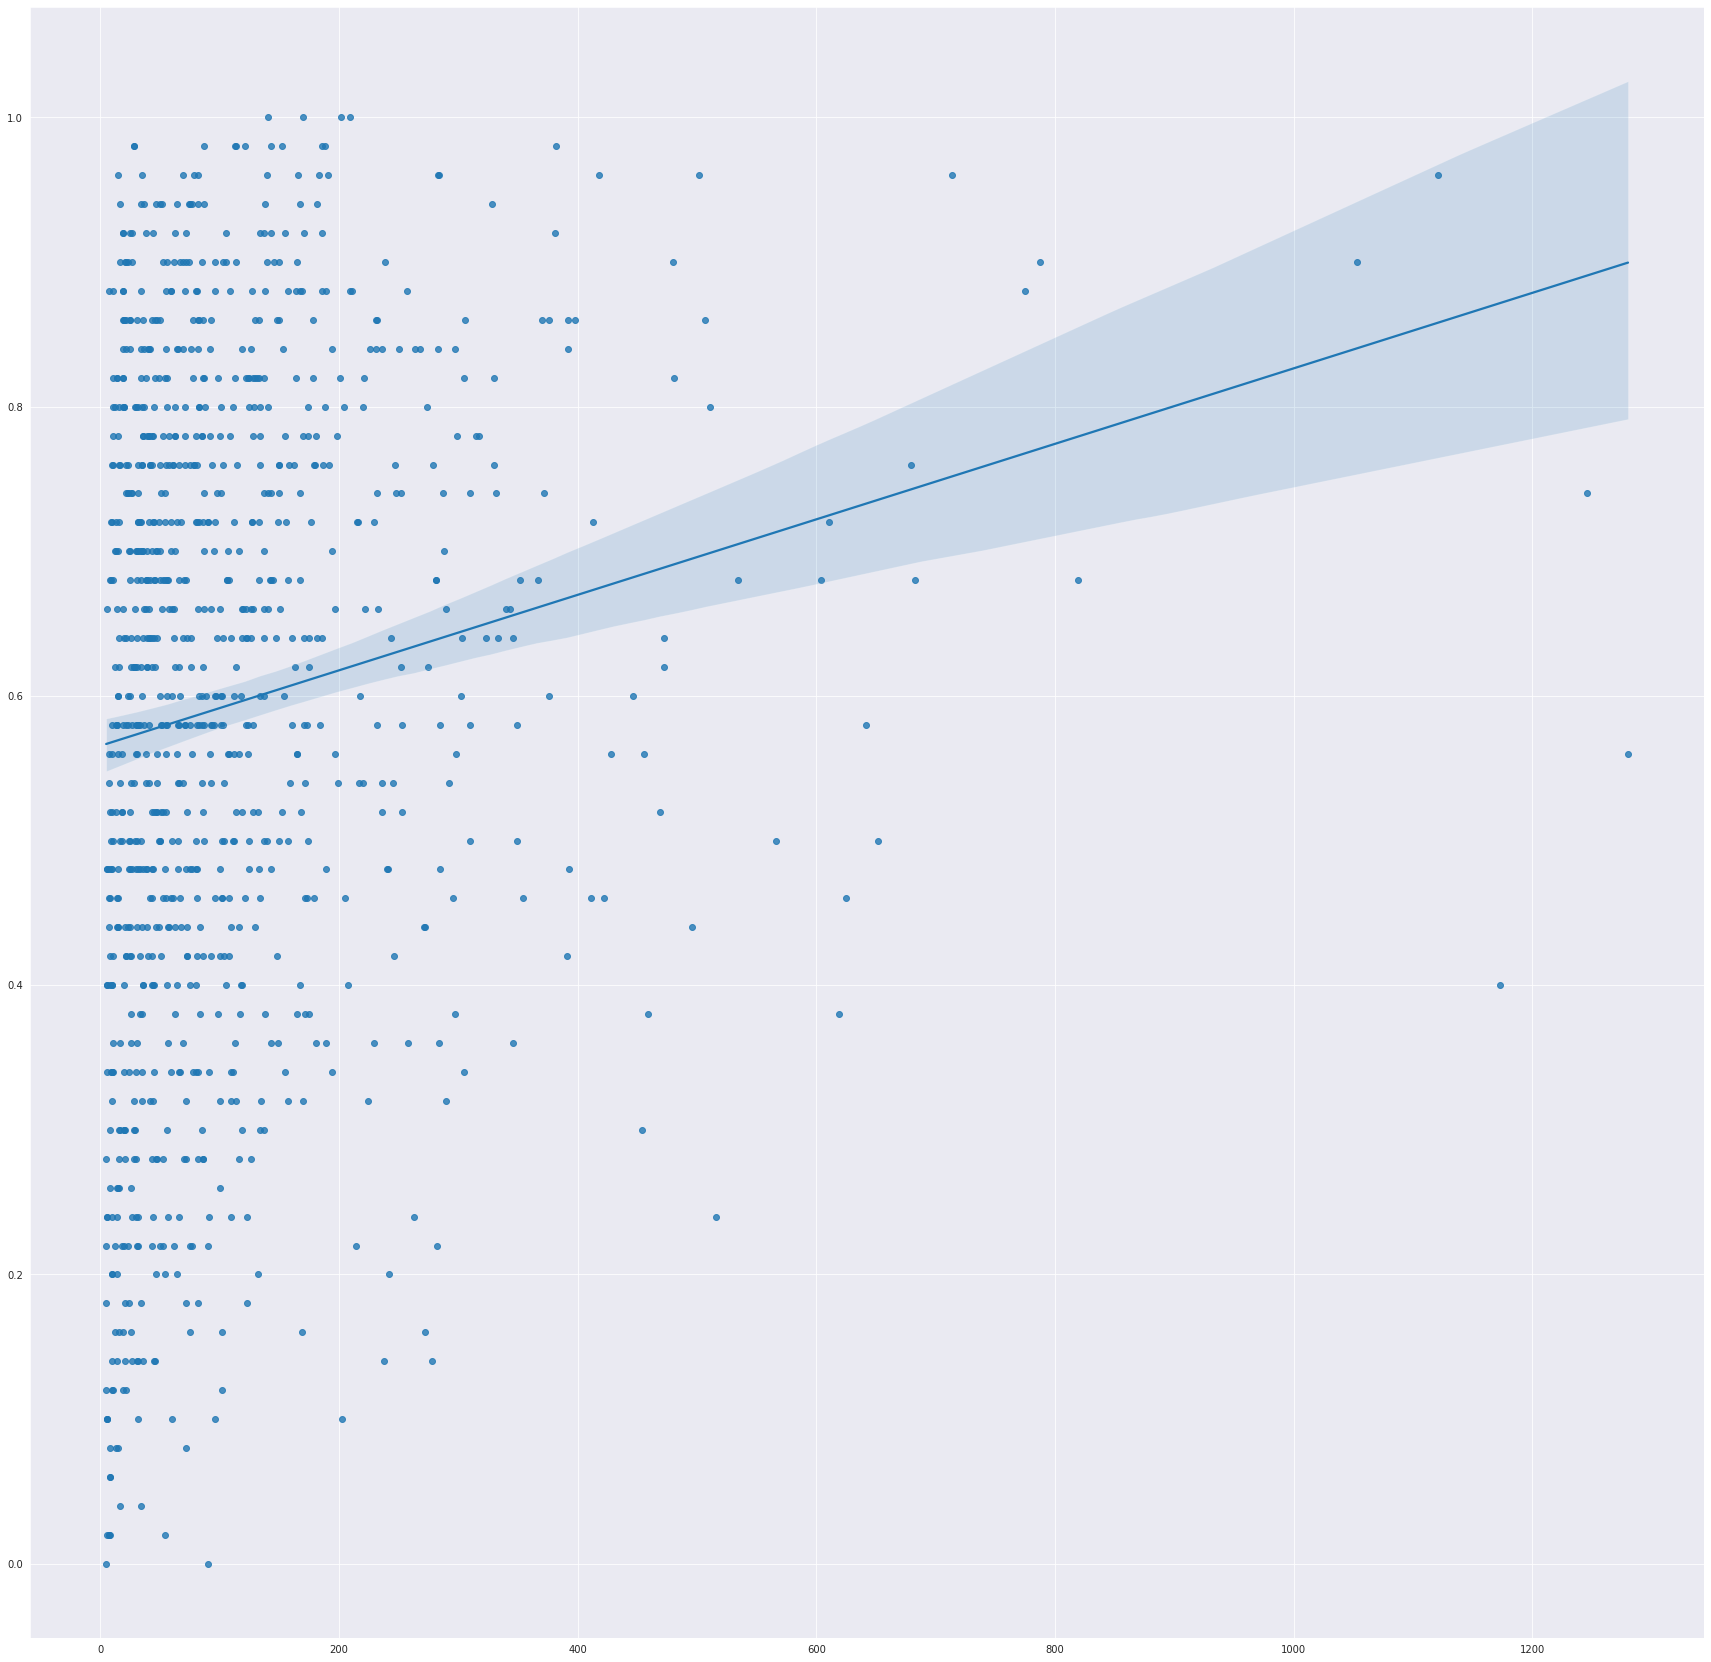

In [163]:
accs = []
cls_freqs = []
for cls in tqdm(labels.unique()):
    m = labels == cls
    indices = m.nonzero()
    acc = mic_acc_cal(predictions_conv_comb_test[indices], labels[indices].numpy())
    accs.append(acc)
    cls_freqs.append(freqs[int(cls)])
    
sns.set_style("darkgrid")
sns.regplot(cls_freqs, accs)

In [166]:
# add to the top k similar text

def conv_comb_top_k_similar(k):
    indices = (-pairwise_cs).argsort(axis=-1)[:, :k]
#     indices = np.argmax(pairwise_cs, axis=-1)
    most_similar_texts = []
    final_ies = []
    for i in tqdm(range(0, 50000)):
        instance_indices = indices[i]
        most_similar_text = np.take_along_axis(text_embs.cpu(), instance_indices[:,None], axis=0)
        most_similar_text = torch.mean(most_similar_text,axis=0)
        most_similar_texts.append(most_similar_text)
        final_ies.append(image_embeddings.cpu()[i,:])
    most_similar_texts = torch.stack(most_similar_texts)
    final_ies = torch.stack(final_ies)

    conv_comb_test = 0.8*(final_ies) + 0.2*(most_similar_texts)
    predictions_conv_comb_test = clf.predict(conv_comb_test)
    avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
    return avg_acc
    
for i in reversed(range(1, 1000, 50)):
    acc = conv_comb_top_k_similar(i)
    print(f"K: {i}, Acc: {acc}")

  0%|          | 0/50000 [00:00<?, ?it/s]

K: 951, Acc: 0.60676


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 901, Acc: 0.60608


  0%|          | 0/50000 [00:00<?, ?it/s]

K: 851, Acc: 0.60564


  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Add closest text at eval time - Synonyms

In [167]:
from classes_synsets import SYNS

In [65]:
all_syns_text = {}
syn_text_embs = []
syn_text_labels = []
avg_syn_text_embs = []
with torch.no_grad():
    for label in tqdm(range(1000)):
        all_syns_text[label] = []
        temp = []
        for syn in SYNS[label]:
            templates = ["a photo of a {}."]
            c = syn
            texts = clip.tokenize([template.format(c) for template in templates]) 
            texts = texts.cuda()
            zeroshot_weights = clip_model.encode_text(texts).float()
            zeroshot_weights = zeroshot_weights / zeroshot_weights.norm(
                dim=-1, keepdim=True
            )
            all_syns_text[label].append(zeroshot_weights)
            temp.append(zeroshot_weights)
            for i in range(len(templates)):
                syn_text_labels.append(label)
        syn_text_embs.extend(temp)
        temp = torch.cat(temp)
        avg_syn_text_embs.append(torch.mean(temp, axis=0))
        
syn_text_embs = torch.cat(syn_text_embs)
avg_syn_text_embs = torch.stack(avg_syn_text_embs)
print(syn_text_embs.shape)
print(avg_syn_text_embs.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([20675, 1024])
torch.Size([1000, 1024])


In [38]:
syns_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), syn_text_embs.cpu())
syns_pairwise_cs.shape

(50000, 20675)

In [170]:
indices = (-syns_pairwise_cs).argsort(axis=-1)

In [172]:
def conv_comb_top_k_similar(k, text_embs, indices):
    indices = indices[:, :k]
#     indices = np.argmax(pairwise_cs, axis=-1)
    most_similar_texts = []
    for i in tqdm(range(0,50000)):
        instance_indices = indices[i]
        most_similar_text = np.take_along_axis(text_embs.cpu(), instance_indices[:,None], axis=0)
        most_similar_text = torch.mean(most_similar_text,axis=0)
        most_similar_texts.append(most_similar_text)
    most_similar_texts = torch.stack(most_similar_texts)

    conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_texts)
    predictions_conv_comb_test = clf.predict(conv_comb_test)
    avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
    return avg_acc
    

for i in reversed(range(1000)):
    acc = conv_comb_top_k_similar(i, syn_text_embs, indices)
    print(f"K: {i}, Acc: {acc}")

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [180]:
# add to the most similar text

indices = np.argmax(syns_pairwise_cs, axis=-1)
most_similar_text = np.take_along_axis(syn_text_embs.cpu(), indices[:,None], axis=0)
print(most_similar_text.shape)

# conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_text)
# predictions_conv_comb_test = clf.predict(conv_comb_test)
# avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
# print(avg_acc)

torch.Size([50000, 1024])


In [181]:
conv_comb_test = 0.8*(many_embs.cpu()) + 0.2*(most_similar_text[many_labels])
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, many_labels)
print("Many", avg_acc)
conv_comb_test = 0.8*(med_embs.cpu()) + 0.2*(most_similar_text[med_labels])
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, med_labels)
print("Med", avg_acc)
conv_comb_test = 0.8*(few_embs.cpu()) + 0.2*(most_similar_text[few_labels])
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, few_labels)
print("Few", avg_acc)
conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_text)
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
print("All", avg_acc)

Many 0.6705882352941176
Med 0.5373784355179704
Few 0.35073529411764703
All 0.565


#### Average prototype across all synonyms

In [66]:
avg_syns_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), avg_syn_text_embs.cpu())
avg_syns_pairwise_cs.shape

(50000, 1000)

In [70]:
# add to the most similar text

indices = np.argmax(avg_syns_pairwise_cs, axis=-1)
print(indices.shape)
most_similar_text = np.take_along_axis(avg_syn_text_embs.cpu(), indices[:,None], axis=0)
print(most_similar_text.shape)

conv_comb_test = 0.8*(image_embeddings.cpu()) + 0.2*(most_similar_text)
predictions_conv_comb_test = clf.predict(conv_comb_test)
avg_acc = mic_acc_cal(predictions_conv_comb_test, labels.numpy())
print(avg_acc)

(50000,)
torch.Size([50000, 1024])
0.5656


In [94]:
# softmaxed = torch.tensor(avg_syns_pairwise_cs).softmax(dim=-1)
# sns.heatmap(softmaxed[0:50000:50,:], cmap="YlGnBu", cbar=False)
# plt.show()

### Alternate Train(?) Scheme: Leveraging CLIP Zero-shot top-K 

In [43]:
def top_k_acc(pairwise_cs, k, labels):
    indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :k]
    acc = 0
    for i in range(indices.shape[0]):
        if labels[i].item() in indices[i]:
            acc +=1.0
    acc/= indices.shape[0]
    return acc

In [44]:
for i in range(1, 20):
    acc = top_k_acc(pairwise_cs, i, labels)
    print(f"Top {i} zero-shot accuracy: {acc}")

Top 1 zero-shot accuracy: 0.5818
Top 2 zero-shot accuracy: 0.7236
Top 3 zero-shot accuracy: 0.78856
Top 4 zero-shot accuracy: 0.82564
Top 5 zero-shot accuracy: 0.8524
Top 6 zero-shot accuracy: 0.87132
Top 7 zero-shot accuracy: 0.88542
Top 8 zero-shot accuracy: 0.89648
Top 9 zero-shot accuracy: 0.9047
Top 10 zero-shot accuracy: 0.91268
Top 11 zero-shot accuracy: 0.91892
Top 12 zero-shot accuracy: 0.92478
Top 13 zero-shot accuracy: 0.92928
Top 14 zero-shot accuracy: 0.93374
Top 15 zero-shot accuracy: 0.93726
Top 16 zero-shot accuracy: 0.9405
Top 17 zero-shot accuracy: 0.9432
Top 18 zero-shot accuracy: 0.94606
Top 19 zero-shot accuracy: 0.94848


In [104]:
import pandas 
pandas.set_option('display.max_rows', None)

indices = (-torch.tensor(pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :3]
vals = np.sort(-torch.tensor(pairwise_cs).softmax(dim=-1).numpy(), axis=-1)[:, :3]
outs = []
for i in range(indices.shape[0]):
    if labels[i].item() == indices[i][1]:
#         if labels[i].item() in indices[i]:
        outs.append([CLASSES[labels[i].item()], CLASSES[indices[i][0]], CLASSES[indices[i][1]], CLASSES[indices[i][2]]])
        outs.append([CLASSES[labels[i].item()], vals[i][0], vals[i][1], vals[i][2]])

df = pd.DataFrame(outs, columns = ['True', 'Pred 1', 'Pred 2', 'Pred 3'])
# df

In [51]:
import pandas 
pandas.set_option('display.max_rows', None)

indices = (-torch.tensor(syns_pairwise_cs).softmax(dim=-1).numpy()).argsort(axis=-1)[:, :3]
outs = []
for i in range(indices.shape[0]):
    outs.append([CLASSES[labels[i].item()], SYN_CLASSES[indices[i][0]], SYN_CLASSES[indices[i][1]], SYN_CLASSES[indices[i][2]]])

df = pd.DataFrame(outs, columns = ['True', 'Pred 1', 'Pred 2', 'Pred 3'])
df

NameError: name 'SYN_CLASSES' is not defined

### Alternate Train(?) scheme: Only FT on Image and only FT on Text

In [112]:
conv_comb_0_8_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))

text_only_balanced_clf = pickle.load(open("results_sklearn/config_text_only_0/29-Sep-2022-01-32-28/final_model.sav", 'rb'))
text_only_balanced_clf_2 = pickle.load(open("results_sklearn/config_text_only_liblinear/06-Nov-2022-01-47-08/final_model.sav", 'rb'))

image_only_clf = pickle.load(open("results_sklearn/config_image_linear_probe_0/class_balanced/13-Sep-2022-01-37-04/final_model.sav", 'rb'))
image_only_clf_2 = pickle.load(open("results_sklearn/config_image_linear_probe_0/class_balanced/13-Sep-2022-01-35-07/final_model.sav", 'rb'))
image_only_clf_3 = pickle.load(open("results_sklearn/config_image_linear_probe_0/balanced/29-Sep-2022-01-38-27/final_model.sav", 'rb'))


In [96]:
avg_acc = mic_acc_cal(conv_comb_0_8_clf.predict(image_embeddings), labels.numpy())
print(avg_acc)

0.62202


In [97]:
avg_acc = mic_acc_cal(text_only_balanced_clf.predict(image_embeddings), labels.numpy())
print(avg_acc)

0.50076


In [107]:
avg_acc = mic_acc_cal(text_only_balanced_clf_2.predict(image_embeddings), labels.numpy())
print(avg_acc)

0.54418


In [98]:
avg_acc = mic_acc_cal(image_only_clf.predict(image_embeddings), labels.numpy())
print(avg_acc)

0.6084


In [113]:
avg_acc = mic_acc_cal(image_only_clf_2.predict(image_embeddings), labels.numpy())
print(avg_acc)

0.59492


In [99]:
# Zero Shot CLIP
acc = top_k_acc(pairwise_cs, 1, labels)
print(acc)

0.5818


In [101]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
for i in range(0, 21):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf.coef_ + (1-i)*image_only_clf.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf.intercept_
    val_acc = mic_acc_cal(mixed_clf.predict(image_embeddings_val), labels_val.numpy())
    test_acc = mic_acc_cal(mixed_clf.predict(image_embeddings), labels.numpy())
    val_accs_range.append(val_acc)
    test_accs_range.append(test_acc)
    print(f"Mixing coeff: {i}, Acc Val: {val_acc}, Acc Test: {test_acc}")

Mixing coeff: 0.0, Acc Val: 0.6208, Acc Test: 0.6084
Mixing coeff: 0.05, Acc Val: 0.62275, Acc Test: 0.61036
Mixing coeff: 0.1, Acc Val: 0.6237, Acc Test: 0.6125
Mixing coeff: 0.15, Acc Val: 0.6259, Acc Test: 0.61464
Mixing coeff: 0.2, Acc Val: 0.6282, Acc Test: 0.61724
Mixing coeff: 0.25, Acc Val: 0.6301, Acc Test: 0.6194
Mixing coeff: 0.3, Acc Val: 0.6328, Acc Test: 0.62136
Mixing coeff: 0.35, Acc Val: 0.63515, Acc Test: 0.62344
Mixing coeff: 0.4, Acc Val: 0.6386, Acc Test: 0.62578
Mixing coeff: 0.45, Acc Val: 0.64075, Acc Test: 0.62874
Mixing coeff: 0.5, Acc Val: 0.6425, Acc Test: 0.6313
Mixing coeff: 0.55, Acc Val: 0.6445, Acc Test: 0.633
Mixing coeff: 0.6, Acc Val: 0.64585, Acc Test: 0.63456
Mixing coeff: 0.65, Acc Val: 0.6476, Acc Test: 0.63598
Mixing coeff: 0.7, Acc Val: 0.6476, Acc Test: 0.63618
Mixing coeff: 0.75, Acc Val: 0.6465, Acc Test: 0.63668
Mixing coeff: 0.8, Acc Val: 0.6416, Acc Test: 0.63222
Mixing coeff: 0.85, Acc Val: 0.63395, Acc Test: 0.62384
Mixing coeff: 0.9, A

In [108]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
for i in range(0, 21):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf_2.intercept_ + (1-i)*image_only_clf.intercept_
    val_acc = mic_acc_cal(mixed_clf.predict(image_embeddings_val), labels_val.numpy())
    test_acc = mic_acc_cal(mixed_clf.predict(image_embeddings), labels.numpy())
    val_accs_range.append(val_acc)
    test_accs_range.append(test_acc)
    print(f"Mixing coeff: {i}, Acc Val: {val_acc}, Acc Test: {test_acc}")

Mixing coeff: 0.0, Acc Val: 0.6208, Acc Test: 0.6084
Mixing coeff: 0.05, Acc Val: 0.6228, Acc Test: 0.61034
Mixing coeff: 0.1, Acc Val: 0.6242, Acc Test: 0.6127
Mixing coeff: 0.15, Acc Val: 0.62635, Acc Test: 0.61492
Mixing coeff: 0.2, Acc Val: 0.62885, Acc Test: 0.61732
Mixing coeff: 0.25, Acc Val: 0.63155, Acc Test: 0.6193
Mixing coeff: 0.3, Acc Val: 0.6336, Acc Test: 0.62162
Mixing coeff: 0.35, Acc Val: 0.6362, Acc Test: 0.62376
Mixing coeff: 0.4, Acc Val: 0.63985, Acc Test: 0.62636
Mixing coeff: 0.45, Acc Val: 0.6437, Acc Test: 0.62932
Mixing coeff: 0.5, Acc Val: 0.64525, Acc Test: 0.63214
Mixing coeff: 0.55, Acc Val: 0.64685, Acc Test: 0.63474
Mixing coeff: 0.6, Acc Val: 0.65015, Acc Test: 0.63654
Mixing coeff: 0.65, Acc Val: 0.6529, Acc Test: 0.6387
Mixing coeff: 0.7, Acc Val: 0.6536, Acc Test: 0.64004
Mixing coeff: 0.75, Acc Val: 0.65455, Acc Test: 0.6394
Mixing coeff: 0.8, Acc Val: 0.65105, Acc Test: 0.63952
Mixing coeff: 0.85, Acc Val: 0.64465, Acc Test: 0.6336
Mixing coeff: 0

In [109]:
mixed_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
val_accs_range = []
test_accs_range = []
many_accs_range = []
med_accs_range = []
few_accs_range = []
for i in range(0, 21):
    i = i/20.0
    mixed_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
    mixed_clf.intercept_ = i*text_only_balanced_clf_2.intercept_ + (1-i)*image_only_clf.intercept_
    many_accs_range.append(mic_acc_cal(mixed_clf.predict(many_embs), many_labels))
    med_accs_range.append(mic_acc_cal(mixed_clf.predict(med_embs), med_labels))
    few_accs_range.append(mic_acc_cal(mixed_clf.predict(few_embs), few_labels))
    print(f"Mixing coeff: {i}, Many: {many_accs_range[-1]}, Med: {med_accs_range[-1]}, Few: {few_accs_range[-1]}")

Mixing coeff: 0.0, Many: 0.7351918158567775, Med: 0.5793657505285412, Few: 0.3448529411764706
Mixing coeff: 0.05, Many: 0.7362148337595908, Med: 0.5816490486257928, Few: 0.34823529411764703
Mixing coeff: 0.1, Many: 0.7376470588235294, Med: 0.5841437632135307, Few: 0.3527941176470588
Mixing coeff: 0.15, Many: 0.7385166240409207, Med: 0.5868498942917547, Few: 0.35720588235294115
Mixing coeff: 0.2, Many: 0.7393350383631714, Med: 0.5901057082452431, Few: 0.3611764705882353
Mixing coeff: 0.25, Many: 0.739693094629156, Med: 0.5926427061310783, Few: 0.3658823529411765
Mixing coeff: 0.3, Many: 0.7405115089514066, Med: 0.5954334038054968, Few: 0.3708823529411765
Mixing coeff: 0.35, Many: 0.741381074168798, Med: 0.597970401691332, Few: 0.37529411764705883
Mixing coeff: 0.4, Many: 0.7423017902813299, Med: 0.6010570824524313, Few: 0.3810294117647059
Mixing coeff: 0.45, Many: 0.7427109974424553, Med: 0.6049048625792812, Few: 0.38823529411764707
Mixing coeff: 0.5, Many: 0.7423529411764705, Med: 0.60

In [114]:
# Quantify agreement between texts

pred1 = image_only_clf.predict(image_embeddings)
pred2 = image_only_clf_2.predict(image_embeddings)

In [128]:
inds = np.where(pred1 != pred2)[0]
disagreed_labels = labels.numpy()[inds]
diagreement_df = {}
for i in disagreed_labels:
    if i not in diagreement_df:
        diagreement_df[i] = [0, freqs[i]]
    diagreement_df[i][0] +=1
diagreement_df = [[k, v[0], v[1]] for k,v in diagreement_df.items()]

diagreement_df = pd.DataFrame(diagreement_df, columns = ['label', 'num dsgrmnts', 'freq'])
diagreement_df

,label,num dsgrmnts,freq
0,505,16,54
1,233,33,51
2,408,10,275
3,26,10,134
4,889,21,50
5,203,21,50
6,394,21,122
7,334,16,48
8,312,24,50
9,242,23,59


/nethome/bdevnani3/flash1/miniconda3/envs/ltr/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


<AxesSubplot:xlabel='freq', ylabel='num dsgrmnts'>

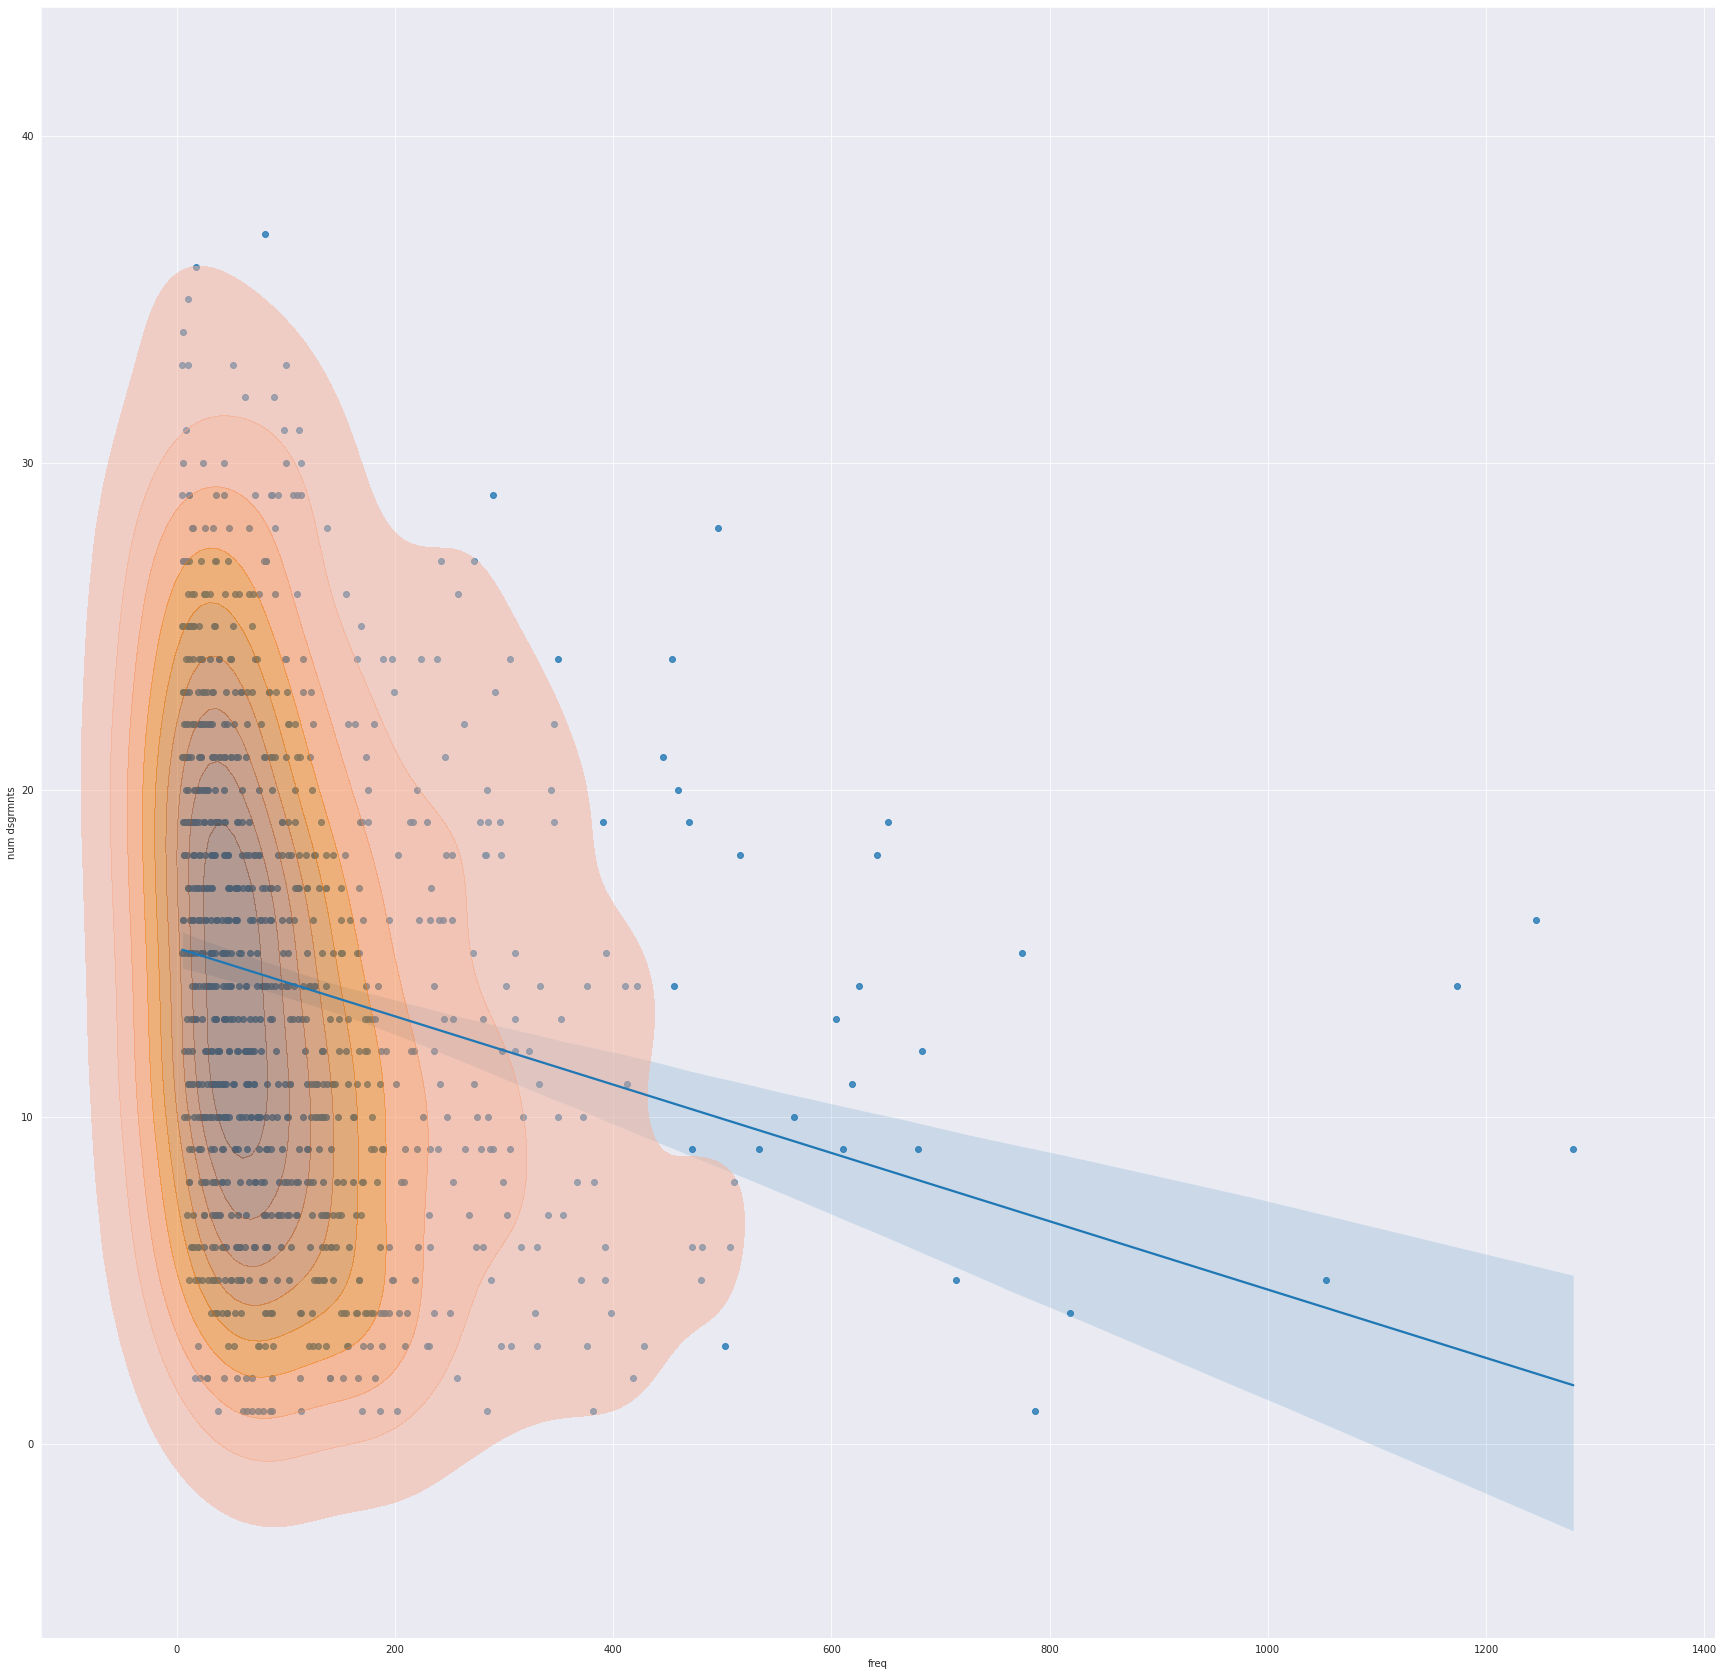

In [131]:
graph = sns.regplot(data=diagreement_df, x = "freq", y = "num dsgrmnts")
sns.kdeplot(data=diagreement_df, x = "freq", y = "num dsgrmnts", fill=True, common_norm=False, palette="crest", alpha=.5, linewidth=0,)



In [110]:
### Adaptively choose mixing coefficient using val set

# explore the confidence of prediction across the various mixtures

# Best Many:
i = 0.45
many_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
many_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
many_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf.intercept_

# Best Med:
i = 0.8
med_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
med_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
med_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf.intercept_

# Best Few:
i = 0.95
few_clf = pickle.load(open("results_sklearn/config_convex_comb_1/13-Sep-2022-00-50-56/final_model.sav", 'rb'))
few_clf.coef_ = i*text_only_balanced_clf_2.coef_ + (1-i)*image_only_clf.coef_
few_clf.intercept_ = i*text_only_balanced_clf.intercept_ + (1-i)*image_only_clf.intercept_

In [111]:
acc = 0
for i in tqdm(range(50000)):
    if freqs[labels[i].item()] >= 100:
        pred = many_clf.predict(image_embeddings[i,:].unsqueeze(0))
    elif freqs[labels[i].item()] >= 20:
        pred = med_clf.predict(image_embeddings[i,:].unsqueeze(0))
    else:
        pred = few_clf.predict(image_embeddings[i,:].unsqueeze(0))
    if pred[0] == labels[i].item():
        acc+=1
        
print(acc/50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

0.64918


### Generate prototypes per class

In [ ]:
image_prototypes = []

for i in range(1000):
    idx = (labels_train == i).nonzero()
    ims = image_embeddings_train[idx, :].squeeze(1).mean(axis=0)
    image_prototypes.append(ims)
    
image_prototypes = torch.stack(image_prototypes)
image_prototypes.shape

In [ ]:
text_prototypes = text_embs

In [ ]:
med_clf.coef_.shape

In [91]:
image_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), image_prototypes.cpu())
print(top_k_acc(image_pairwise_cs, 1, labels))

image_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(many_embs.cpu(), image_prototypes.cpu())
print(top_k_acc(image_pairwise_cs, 1, many_labels))

image_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(med_embs.cpu(), image_prototypes.cpu())
print(top_k_acc(image_pairwise_cs, 1, med_labels))

image_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(few_embs.cpu(), image_prototypes.cpu())
print(top_k_acc(image_pairwise_cs, 1, few_labels))


0.51652
0.5766751918158568
0.5063424947145877
0.3789705882352941


In [95]:
text_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), text_prototypes.cpu())
print(top_k_acc(text_pairwise_cs, 1, labels))

text_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(many_embs.cpu(), text_prototypes.cpu())
print(top_k_acc(text_pairwise_cs, 1, many_labels))

text_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(med_embs.cpu(), text_prototypes.cpu())
print(top_k_acc(text_pairwise_cs, 1, med_labels))

text_pairwise_cs = sklearn.metrics.pairwise.cosine_similarity(few_embs.cpu(), text_prototypes.cpu())
print(top_k_acc(text_pairwise_cs, 1, few_labels))

0.58142
0.591611253196931
0.574799154334038
0.5751470588235295


In [96]:
learned_prototypes = sklearn.metrics.pairwise.cosine_similarity(image_embeddings.cpu(), many_clf.coef_)
print(top_k_acc(learned_prototypes, 1, labels))

learned_prototypes = sklearn.metrics.pairwise.cosine_similarity(many_embs.cpu(), many_clf.coef_)
print(top_k_acc(learned_prototypes, 1, many_labels))

learned_prototypes = sklearn.metrics.pairwise.cosine_similarity(med_embs.cpu(), many_clf.coef_)
print(top_k_acc(learned_prototypes, 1, med_labels))

learned_prototypes = sklearn.metrics.pairwise.cosine_similarity(few_embs.cpu(), many_clf.coef_)
print(top_k_acc(learned_prototypes, 1, few_labels))

0.48866
0.48439897698209716
0.4838054968287526
0.5177941176470588
